# Libraries

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
import fx_rl
# import MetaTrader5 as mt5

# Gathering Data

In [ ]:
full_15_min_ohlc

In [74]:
pl.read_csv(f'EURUSD_full_tickstory_data_15_min.csv')

,Open,High,Low,Close
str,f64,f64,f64,f64
"""2016-08-01 03:00:00""",1.11672,1.1175,1.1166,1.1175
"""2016-08-01 03:15:00""",1.11749,1.11767,1.11692,1.11701
"""2016-08-01 03:30:00""",1.11701,1.1174,1.1167,1.11732
"""2016-08-01 03:45:00""",1.11732,1.11761,1.11694,1.1175
"""2016-08-01 04:00:00""",1.1175,1.11782,1.11728,1.11729
…,…,…,…,…
"""2024-08-09 22:45:00""",1.09183,1.09189,1.09179,1.09187
"""2024-08-09 23:00:00""",1.09186,1.09194,1.09167,1.09168
"""2024-08-09 23:15:00""",1.09168,1.09179,1.09167,1.09175


In [77]:
df_w_news = (
    pl.scan_csv(f'EURUSD_full_tickstory_data_15_min_ready.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('Datetime').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),
        pl.arange(0, pl.len()).alias('ds'),
        # .dt.replace_time_zone('UTC'),
        # add a column that takes the sum of 'Open' 'High' 'Low' and 'Close' and divides it by 4
        pl.col('Close').alias('y')
    ])
    # .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y', 'seconds_since_last_news_event', 'seconds_to_next_news_event', 'Datetime'))
    )

# Load the second CSV file and rename columns
df_crossvalidation = (
    pl.scan_csv('crossvalidation_df_RWD.csv')
    .select([
        # pl.col('cutoff').alias('ds'),
        pl.col('ds'),
        # round to 5 decimal places
        pl.col('RWD').alias('Pred') #.round(5)
    ])
)

full_ohlc_15min_df = (
    pl.scan_csv('EURUSD_full_tickstory_data_15_min.csv')
    .with_columns([
        # pl.col('cutoff').alias('ds'),
        pl.col('').alias('Datetime').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),
    ])
    .drop('')
)

# Join the DataFrames on the 'ds' column
df_joined = df_w_news.join(df_crossvalidation, on='ds', how='inner').join(full_ohlc_15min_df, on='Datetime', how='left').collect()

df_joined

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime,Pred,Open,High,Low,Close
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64
"""EURUSD""",40005,1.23897,-64800,31500,2018-03-08 11:00:00,1.2397732,1.23925,1.23942,1.2382,1.239
"""EURUSD""",40006,1.23891,-65700,30600,2018-03-08 11:15:00,1.2389731,1.23899,1.23922,1.23851,1.23891
"""EURUSD""",40007,1.23863,-66600,29700,2018-03-08 11:30:00,1.238913,1.23892,1.23893,1.2383,1.23838
"""EURUSD""",40008,1.23828,-67500,28800,2018-03-08 11:45:00,1.238633,1.23837,1.23868,1.2378,1.23826
"""EURUSD""",40009,1.23834,-68400,27900,2018-03-08 12:00:00,1.238283,1.23825,1.23879,1.23776,1.23856
…,…,…,…,…,…,…,…,…,…,…
"""EURUSD""",200332,1.09185,-297900,146700,2024-08-09 22:45:00,1.0918499,1.09183,1.09189,1.09179,1.09187
"""EURUSD""",200333,1.09179,-298800,145800,2024-08-09 23:00:00,1.0918499,1.09186,1.09194,1.09167,1.09168
"""EURUSD""",200334,1.09172,-299700,144900,2024-08-09 23:15:00,1.0917898,1.09168,1.09179,1.09167,1.09175


In [14]:

# df_processed = fcst.preprocess(df_joined, static_features=[])
max_date_1hr = df_joined.select(pl.col('Datetime').max()).item()
testing = True
if testing:
    train, validation, test = fx_rl.slices_finder_polars(df_joined, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.select(*df_joined.columns).drop("Datetime")
    validation = validation.drop("Datetime")
    test = test.drop("Datetime")
else:
    train, validation = fx_rl.slices_finder_polars(df_joined, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.select(*df_joined.columns).drop("Datetime")
    validation = validation.drop("Datetime")
train

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Pred
str,i64,f64,i64,i64,f64
"""EURUSD""",40004,1.23977,-63900,32400,1.23977
"""EURUSD""",40005,1.23897,-64800,31500,1.23897
"""EURUSD""",40006,1.23891,-65700,30600,1.23891
"""EURUSD""",40007,1.23863,-66600,29700,1.23863
"""EURUSD""",40008,1.23828,-67500,28800,1.23828
…,…,…,…,…,…
"""EURUSD""",199371,1.08576,-25200,135000,1.08576
"""EURUSD""",199372,1.08572,-26100,134100,1.08572
"""EURUSD""",199373,1.08569,-27000,133200,1.08569


## Parameters

In [90]:
# Renko variable
# brick_size = 0.00081
# # multiply brick_size by 10,000 to get a whole number
# brick_size_str = str(int(brick_size*100000))

# sma variables
sma_length = 4
smoothing_sma = 4

# Lot Size
lot_size = 3
per_lot = 100_000

# pyramid
pyramid_size = 4
pyramid_bool = True

# stop loss
stop_loss_size = 0.00033*2
# threshold for entry
threshold = 0.00033*3

# take profit
take_profit_size = 0.00033*4

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

## Entry conditions

In [18]:
# create a string of 80 '#' characters
hashes = '#' * 80
# print the hashes string
print(hashes)

################################################################################


In [100]:
# create a column called Pred_lag1 which is the lag of the Pred column in polars
df_joined_lag5 = df_joined.with_columns(
    # pl.col("Pred").shift(-1).alias("Pred_lag1"),
    pl.col("Pred").shift(-5).alias("Pred_lag5"),
).drop_nulls(subset=["Pred_lag5"])
# create the buy and sell signals which is that if the Pred_lag1 is greater than the y by threshold then buy and if the Pred_lag1 is less than the y by threshold then sell
df_joined_bs = df_joined_lag5.with_columns(
    (pl.col("Pred_lag5") > pl.col("y") + threshold).cast(pl.Int8).alias("buy"),
    (pl.col("Pred_lag5") < pl.col("y") - threshold).cast(pl.Int8).alias("sell"),
    # (pl.col('y') - pl.col('Pred_lag1')).alias("y_diff")
)

# create a column called signal which is the buy column if the buy column is 1 and the sell column is 0 and the sell column * -1 if the buy column is 0 and the sell column is 1 and 0 if the buy column is 0 and the sell column is 0
df_joined_signal = df_joined_bs.with_columns(
    (pl.col("buy") + (pl.col("sell") * -1)).alias("signal"),
)
df_joined_signal

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime,Pred,Open,High,Low,Close,Pred_lag5,buy,sell,signal
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,i8,i8,i8
"""EURUSD""",40005,1.23897,-64800,31500,2018-03-08 11:00:00,1.2397732,1.23925,1.23942,1.2382,1.239,1.238343,0,0,0
"""EURUSD""",40006,1.23891,-65700,30600,2018-03-08 11:15:00,1.2389731,1.23899,1.23922,1.23851,1.23891,1.2385529,0,0,0
"""EURUSD""",40007,1.23863,-66600,29700,2018-03-08 11:30:00,1.238913,1.23892,1.23893,1.2383,1.23838,1.2382929,0,0,0
"""EURUSD""",40008,1.23828,-67500,28800,2018-03-08 11:45:00,1.238633,1.23837,1.23868,1.2378,1.23826,1.238013,0,0,0
"""EURUSD""",40009,1.23834,-68400,27900,2018-03-08 12:00:00,1.238283,1.23825,1.23879,1.23776,1.23856,1.2375829,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""EURUSD""",200327,1.09179,-293400,151200,2024-08-09 21:30:00,1.0918999,1.0918,1.09188,1.0917,1.0918,1.0918499,0,0,0
"""EURUSD""",200328,1.09189,-294300,150300,2024-08-09 21:45:00,1.0917898,1.0918,1.09201,1.09179,1.09195,1.0918499,0,0,0
"""EURUSD""",200329,1.09196,-295200,149400,2024-08-09 22:00:00,1.0918899,1.09195,1.09211,1.09186,1.09194,1.0917898,0,0,0


In [101]:
# get the date without the time from 'Datetime' from df_joined_signal which is a polars dataframe
daily = df_joined_signal.select(pl.col('Datetime').dt.date()).unique()
daily.count()

Datetime
u32
1674


In [102]:
# find the sum of signal
df_joined_signal.sum()
# 18 signals per day

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime,Pred,Open,High,Low,Close,Pred_lag5,buy,sell,signal
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,i64,i64,i64
null,19266174936,179499.14583,-11707711800,12055880100,null,179499.319435,179499.26855,179552.213307,179445.639791,179499.02018,179498.583769,14961,15557,-596


In [103]:
# adjust signal to have the word 'buy' if it is 1 and 'sell' if it is -1 and "" if it is 0 for df_joined_signal which is a polars dataframe
df_joined_signal_txt = df_joined_signal.with_columns(
    pl.when(pl.col('signal') == 1)
    .then(pl.lit('buy'))
    .when(pl.col('signal') == -1)
    .then(pl.lit('sell'))
    .otherwise(pl.lit(None))
    .alias('signal_text'),
    # add a column for the day of the week 
    pl.col('Datetime').dt.weekday().alias('day_of_week'),
    pl.col('Datetime').dt.week().alias('week_of_year'),
)
# add a column to indicate a transition between weeks by placing a 1 in the column if the week of year changes in the next row
df_joined_week_trans = df_joined_signal_txt.with_columns(
    pl.when((pl.col('week_of_year') != pl.col('week_of_year').shift(-1)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(1)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(2)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(3)))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias('week_transition')
)
# df_joined_week_trans

In [104]:
# if the week_transition is 1 and signal is not 0 then replace signal_text with 'exit' for the df_joined_week_trans polars dataframe
df_joined_week_trans_exit = df_joined_week_trans.with_columns(
    pl.when(
        (pl.col("week_transition") == 1) & (pl.col("signal") != 0)
    )
    .then(pl.lit("exit"))
    .otherwise(pl.col("signal_text")).alias("signal_text")
)

In [106]:
# add a column called 'Position' that will be 'open' if 'signal_text' is not null and not 'exit', and the previous row is null for df_joined_week_trans_exit a polars df
df_joined_pos = df_joined_week_trans_exit.with_columns(
    pl.when(
        (pl.col('signal_text').is_not_null()) & (pl.col('signal_text') != 'exit') & (pl.col('signal_text').shift().is_null())
    ).then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias('position')
)
# add a take_profit and stop_loss columns which use the variables take_profit_size and stop_loss_size to calculate the take_profit and stop_loss values for each open position
# So when 'Position' column == 1 and signal_text == 'buy' then take_profit = close + take_profit_size and stop_loss = close - stop_loss_size and the opposite for 'sell' for the df_joined_pos polars df
df_joined_tp_sl = df_joined_pos.with_columns(
    pl.when((pl.col('position') == 1) & (pl.col('signal_text') == 'buy'))
    .then(pl.col('Close') + take_profit_size)
    .when((pl.col('position') == 1) & (pl.col('signal_text') == 'sell'))
    .then(pl.col('Close') - take_profit_size)
    .otherwise(None)
    .alias('take_profit'),
    pl.when((pl.col('position') == 1) & (pl.col('signal_text') == 'buy'))
    .then(pl.col('Close') - stop_loss_size)
    .when((pl.col('position') == 1) & (pl.col('signal_text') == 'sell'))
    .then(pl.col('Close') + stop_loss_size)
    .otherwise(None)
    .alias('stop_loss'),
    # find the cumulative sum of the 'position' column and store it in a new column called 'position_cumsum'
    pl.col('position').cum_sum().alias('position_cumsum')
)
df_joined_tp_sl

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime,Pred,Open,High,Low,Close,Pred_lag5,buy,sell,signal,signal_text,day_of_week,week_of_year,week_transition,position,take_profit,stop_loss,position_cumsum
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,i8,i8,i8,str,i8,i8,i32,i32,f64,f64,i32
"""EURUSD""",40005,1.23897,-64800,31500,2018-03-08 11:00:00,1.2397732,1.23925,1.23942,1.2382,1.239,1.238343,0,0,0,null,4,10,0,0,null,null,0
"""EURUSD""",40006,1.23891,-65700,30600,2018-03-08 11:15:00,1.2389731,1.23899,1.23922,1.23851,1.23891,1.2385529,0,0,0,null,4,10,0,0,null,null,0
"""EURUSD""",40007,1.23863,-66600,29700,2018-03-08 11:30:00,1.238913,1.23892,1.23893,1.2383,1.23838,1.2382929,0,0,0,null,4,10,0,0,null,null,0
"""EURUSD""",40008,1.23828,-67500,28800,2018-03-08 11:45:00,1.238633,1.23837,1.23868,1.2378,1.23826,1.238013,0,0,0,null,4,10,0,0,null,null,0
"""EURUSD""",40009,1.23834,-68400,27900,2018-03-08 12:00:00,1.238283,1.23825,1.23879,1.23776,1.23856,1.2375829,0,0,0,null,4,10,0,0,null,null,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""EURUSD""",200327,1.09179,-293400,151200,2024-08-09 21:30:00,1.0918999,1.0918,1.09188,1.0917,1.0918,1.0918499,0,0,0,null,5,32,0,0,null,null,9951
"""EURUSD""",200328,1.09189,-294300,150300,2024-08-09 21:45:00,1.0917898,1.0918,1.09201,1.09179,1.09195,1.0918499,0,0,0,null,5,32,0,0,null,null,9951
"""EURUSD""",200329,1.09196,-295200,149400,2024-08-09 22:00:00,1.0918899,1.09195,1.09211,1.09186,1.09194,1.0917898,0,0,0,null,5,32,0,0,null,null,9951


In [32]:
renko_full_data.loc[renko_full_data['news_event_5'] == 1, 
                                     ['datetime_5', 'datetime_neg_5', 'news_event_5', 
                                     'nova_cum_position_count','msolutions_cum_position_count',
                                       'sma_signal', 'secs_until_next_news_event']]

,datetime_5,datetime_neg_5,news_event_5,nova_cum_position_count,msolutions_cum_position_count,sma_signal,secs_until_next_news_event
datetime,,,,,,,
2022-11-15 16:55:51.916,2022-11-15 17:00:51.916,2022-11-15 16:50:51.916,1,7,None,sell,248.084
2022-11-15 19:00:25.591,2022-11-15 19:05:25.591,2022-11-15 18:55:25.591,1,9,None,sell,12574.409
2022-11-15 19:02:03.071,2022-11-15 19:07:03.071,2022-11-15 18:57:03.071,1,9,None,sell,12476.929
2022-11-15 19:03:36.851,2022-11-15 19:08:36.851,2022-11-15 18:58:36.851,1,9,None,sell,12383.149
2022-11-16 17:55:48.528,2022-11-16 18:00:48.528,2022-11-16 17:50:48.528,1,24,None,buy,251.472
...,...,...,...,...,...,...,...
2024-03-20 21:01:22.295,2024-03-20 21:06:22.295,2024-03-20 20:56:22.295,1,942,None,buy,1717.705
2024-03-21 11:15:00.216,2024-03-21 11:20:00.216,2024-03-21 11:10:00.216,1,942,None,buy,899.784
2024-03-21 11:15:00.269,2024-03-21 11:20:00.269,2024-03-21 11:10:00.269,1,942,None,buy,899.731


In [33]:
## finding out where the stoploss was hit, if stoploss is brick_size*2 and the sma_length and smoothing_length are 3 then the stoploss makes no difference because we are exiting anyways
## it is just good protection in case the order doesn't close correctly via the broker
# forward fill the stoploss
renko_full_data['stop_loss'] = renko_full_data['stop_loss'].ffill()
# determine if any stoploss is hit and if so create a new column called 'stop_loss_hit' and place a 1 in it
renko_full_data['stop_loss_hit'] = np.where((renko_full_data['sma_signal'] == 'buy') & (renko_full_data['low'] < renko_full_data['stop_loss']), 1, 
                                           np.where((renko_full_data['sma_signal'] == 'sell') & (renko_full_data['high'] > renko_full_data['stop_loss']), 1, 0))
stop_loss_hit_df = renko_full_data[renko_full_data['stop_loss_hit'] == 1]
# stop_loss_hit_df

In [34]:
renko_full_data.columns = renko_full_data.columns.str.lower()

In [35]:
# find the counts of null values in every column of renko_full_data
renko_full_data.isnull().sum()


open                                0
high                                0
low                                 0
close                               0
volume                              0
ohlc4                               0
sma                                 3
smoothing_sma                       6
sma_diff                            6
sma_sign                            6
sma_crossover                       0
sma_signal                         14
brick_color                         0
day_of_week                         0
day_of_week_transition              0
take_profit                      5693
stop_loss                          14
datetime_5                          0
datetime_neg_5                      0
news_event_5                        0
secs_until_next_news_event          0
position_count                      0
nova_cum_position_count           520
msolutions_cum_position_count    1108
stop_loss_hit                       0
dtype: int64

In [37]:
len(renko_full_data.open)

6640

In [ ]:
features = ['open', 'high', 'low', 'close', 'sma', 'smoothing_sma',
'sma_diff', 'sma_sign', 'sma_crossover', 
'bollinger_width', 'awesome_oscillator', 'day_of_week_transition',
'news_event_5', 'secs_until_next_news_event']
# drop rows with null values in features
renko_full_data = renko_full_data.dropna(subset=features)


In [46]:
renko_full_data.loc['2024-03-25 00:00:00':, ['sma_signal', 'nova_cum_position_count']]

,sma_signal,nova_cum_position_count
datetime,,
2024-03-25 01:00:03.403,exit,None
2024-03-25 05:46:38.994,exit,None
2024-03-25 15:03:47.132,exit,None
2024-03-25 16:47:09.870,buy,944
2024-03-26 08:47:24.883,buy,944
2024-03-26 12:30:14.353,buy,944
2024-03-26 13:30:01.391,buy,944
2024-03-26 17:22:58.711,buy,944
2024-03-26 18:04:53.019,buy,944


## Specific Day

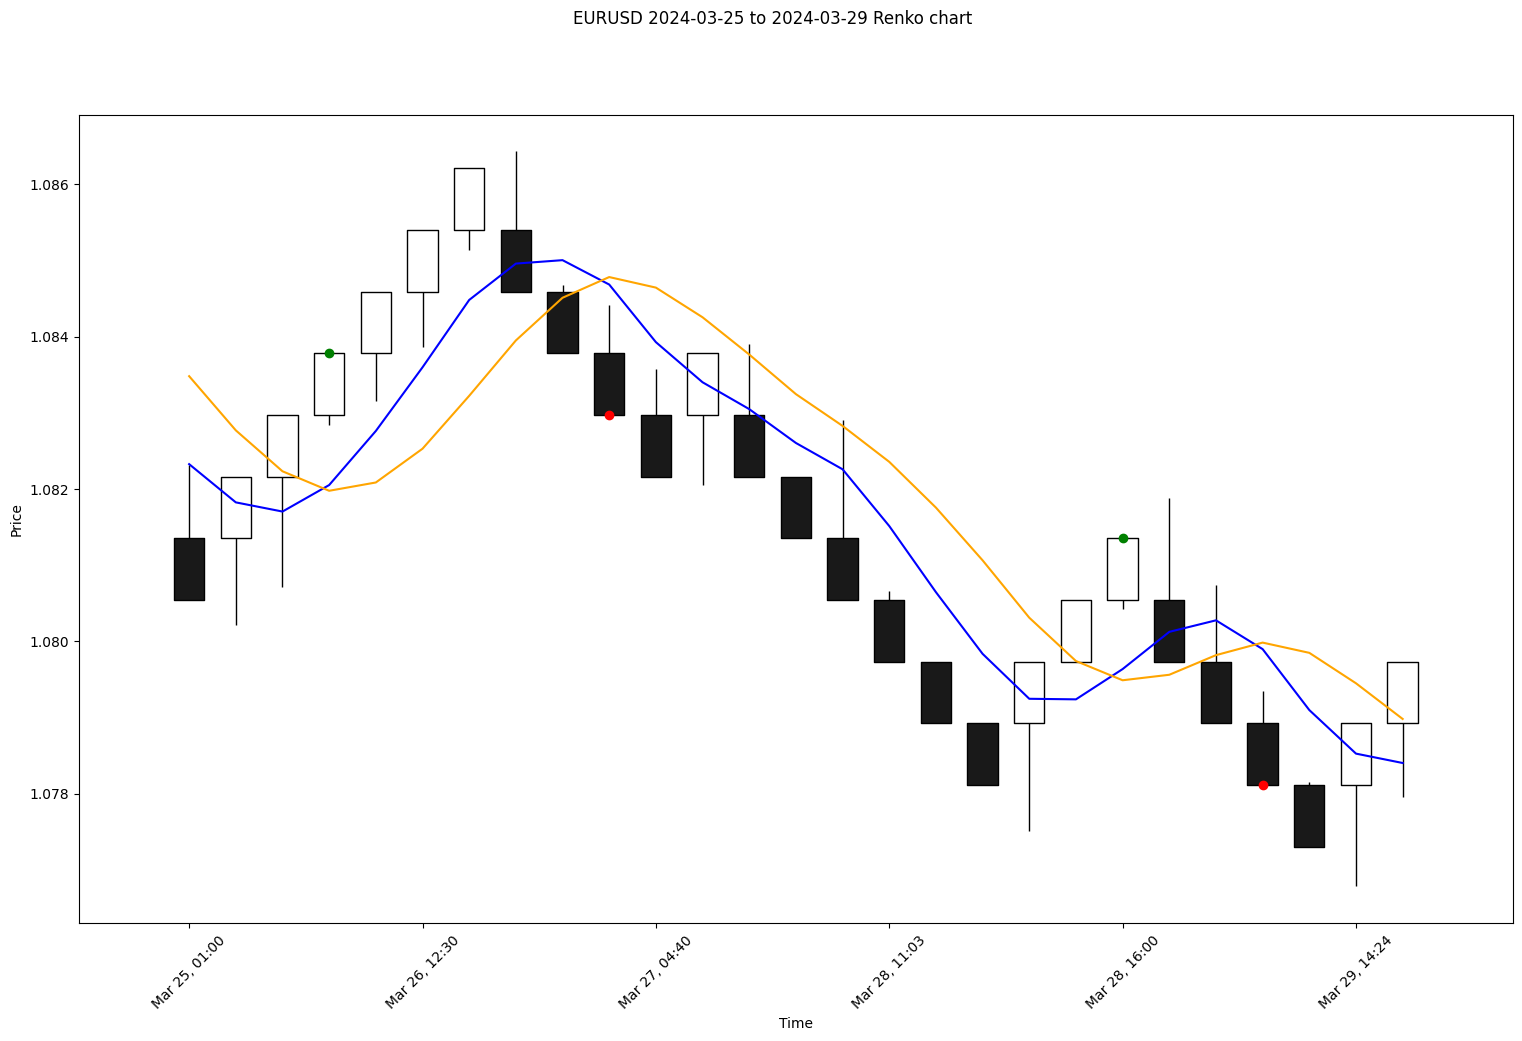

In [40]:
# filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
renko_full_data_select_day = renko_full_data.loc['2024-03-25 00:00:00':'2024-03-30 23:59:59']
# impulse_graph(renko_full_data_select_day, 'md', 'sb')
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_select_day, type='candle', ax=ax, volume=False, show_nontrading=False)
renko_full_data_select_day_reset = renko_full_data_select_day.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_select_day_reset.index, renko_full_data_select_day['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_select_day_reset.index, renko_full_data_select_day['smoothing_sma'], label='SmoothingSMA', color='orange')
# add a column to renko_full_data_select_day_reset that copies the close price when sma_crossover is 1 or -1
renko_full_data_select_day_reset['sma_crossover_price_buy'] = np.where(renko_full_data_select_day['sma_crossover'] == 1, renko_full_data_select_day['close'], np.nan)
renko_full_data_select_day_reset['sma_crossover_price_sell'] = np.where(renko_full_data_select_day['sma_crossover'] == -1, renko_full_data_select_day['close'], np.nan)
# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(renko_full_data_select_day_reset.index, renko_full_data_select_day_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(renko_full_data_select_day_reset.index, renko_full_data_select_day_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# find the date of the first and last index
first_date = renko_full_data_select_day_reset['datetime'].iloc[0]
last_date = renko_full_data_select_day_reset['datetime'].iloc[-1]
fig.suptitle(f'EURUSD {first_date.date()} to {last_date.date()} Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [41]:
# bring in the spread data
spread = pd.read_csv('spread_results_03_11_24_03_12_24.csv', index_col=0)
# convert the column names and index to lowercase
spread.columns = spread.columns.str.lower()
spread.index = spread.index.str.lower()
spread

,msolutions,nova
spread buy,0.000095,0.00007
spread sell,-0.000110,-0.00003
close spread buy,-0.000110,-0.00010
close spread sell,0.000080,0.00008


In [42]:
profit_df_select_day = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
for acct_name in ['nova', 'msolutions']:
        # calculate the profit for each position by first grouping by each position and finding the entry price
        profit_df_select_day[acct_name + '_entry_price'] = renko_full_data_select_day.groupby(acct_name + '_cum_position_count')['close'].first()
        # separate out the datetime column
        renko_full_data_select_day.loc[:, 'datetime'] = renko_full_data_select_day.index
        profit_df_select_day[acct_name + '_entry_time'] = renko_full_data_select_day.groupby(acct_name + '_cum_position_count')['datetime'].first()
        profit_df_select_day[acct_name + '_exit_time'] = renko_full_data_select_day.groupby(acct_name + '_cum_position_count')['datetime'].last()
        # # determine the exit price
        profit_df_select_day[acct_name + '_exit_price'] = renko_full_data_select_day.groupby(acct_name + '_cum_position_count')['close'].last()

        # # what was the direction, buy or short?
        profit_df_select_day[acct_name + '_direction'] = renko_full_data_select_day.groupby(acct_name + '_cum_position_count')['sma_signal'].first()
        # what was the brick color when the position was entered?
        # profit_df_select_day['brick_color'] = renko_full_data_select_day.groupby('cum_position_count')['brick_color'].first()
        # profit_df_select_day['direction'] = profit_df_select_day['direction'].str.split('+').str[1]

        # what if I didn't take the first TP?
        profit_df_select_day[acct_name + '_profit_initial'] = np.where((profit_df_select_day[acct_name + '_direction'].str.strip() == 'buy'),
                                                ((profit_df_select_day[acct_name + '_exit_price'] + spread.loc['close spread buy', acct_name]) - 
                                                 (profit_df_select_day[acct_name + '_entry_price'] + spread.loc['spread buy', 'nova']))
                                                        * per_lot * (lot_size), 
                                                np.where((profit_df_select_day[acct_name + '_direction'].str.strip() == 'sell'),
                                                        ((profit_df_select_day[acct_name + '_entry_price'] + spread.loc['spread sell', 'nova']) - 
                                                         (profit_df_select_day[acct_name + '_exit_price'] + spread.loc['close spread sell', acct_name]))
                                                        * per_lot * (lot_size), np.nan))
        profit_df_select_day = fx.add_swap_rates(profit_df_select_day, base_currency_rate, quote_currency_rate, lots=lot_size, acct=acct_name)
        profit_df_select_day[acct_name + '_profit'] = profit_df_select_day[acct_name + '_profit_initial'] + globals()[acct_name + '_commission']

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_6396\2879595427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_select_day.loc[:, 'datetime'] = renko_full_data_select_day.index


In [43]:
profit_df_select_day

,nova_entry_price,nova_entry_time,nova_exit_time,nova_exit_price,nova_direction,nova_profit_initial,nova_swap,nova_swap_rate,nova_profit,msolutions_entry_price,msolutions_entry_time,msolutions_exit_time,msolutions_exit_price,msolutions_direction,msolutions_profit_initial,msolutions_swap,msolutions_swap_rate,msolutions_profit
nova_cum_position_count,,,,,,,,,,,,,,,,,,
944,1.08378,2024-03-25 16:47:09.870,2024-03-26 18:04:53.019,1.08378,buy,-51.0,0,0.0,-60.0,1.08378,2024-03-25 16:47:09.870,2024-03-26 18:04:53.019,1.08378,buy,-54.0,0,0.0,-69.0
945,1.08297,2024-03-26 18:55:02.943,2024-03-28 15:58:24.402,1.08054,sell,696.0,0,0.0,687.0,1.08297,2024-03-26 18:55:02.943,2024-03-28 15:58:24.402,1.08054,sell,696.0,0,0.0,681.0
946,1.08135,2024-03-28 16:00:39.253,2024-03-28 21:49:37.638,1.07892,buy,-780.0,0,0.0,-789.0,1.08135,2024-03-28 16:00:39.253,2024-03-28 21:49:37.638,1.07892,buy,-783.0,0,0.0,-798.0
947,1.07811,2024-03-29 04:28:38.860,2024-03-29 15:40:08.352,1.07973,sell,-519.0,0,0.0,-528.0,1.07811,2024-03-29 04:28:38.860,2024-03-29 15:40:08.352,1.07973,sell,-519.0,0,0.0,-534.0


In [44]:
# find the sum of nova_profit and msolutions_profit
nova_sum = profit_df_select_day['nova_profit'].sum()
msolutions_sum = profit_df_select_day['msolutions_profit'].sum()
print(f'Nova: {nova_sum}', f'MSolutions: {msolutions_sum}')

Nova: -690.0000000000213 MSolutions: -719.9999999999272


In [39]:
#export stop_loss_hit_df to csv
# stop_loss_hit_df.to_csv('stop_loss_hit_df.csv')

In [40]:
# sma_0 = renko_full_data[renko_full_data['sma_sign'] == 0]
# get a list of the cum_position_count values
# cum_position_count_list = list(sma_0['cum_position_count'].dropna().unique())
# sma_0

## Find the P/L

In [41]:
spread

,msolutions,nova
spread buy,0.000095,0.00007
spread sell,-0.000110,-0.00003
close spread buy,-0.000110,-0.00010
close spread sell,0.000080,0.00008


In [42]:
profit_df = pd.DataFrame() #columns=[acct_name + '_cum_position_count', acct_name + '_direction', acct_name + '_entry_price', acct_name + '_exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
for acct_name in ['nova', 'msolutions']:
        profit_df[acct_name + '_entry_price'] = renko_full_data.groupby(acct_name + '_cum_position_count')['close'].first()
        # separate out the datetime column
        renko_full_data.loc[:, 'datetime'] = renko_full_data.index
        profit_df[acct_name + '_entry_time'] = renko_full_data.groupby(acct_name + '_cum_position_count')['datetime'].first()
        profit_df[acct_name + '_exit_time'] = renko_full_data.groupby(acct_name + '_cum_position_count')['datetime'].last()
        # # determine the exit price
        profit_df[acct_name + '_exit_price'] = renko_full_data.groupby(acct_name + '_cum_position_count')['close'].last()

        # # what was theacct_name +  _direction, buy or short?
        profit_df[acct_name + '_direction'] = renko_full_data.groupby(acct_name + '_cum_position_count')['sma_signal'].first()
        # what was the brick color when the position was entered?
        profit_df[acct_name + '_brick_color'] = renko_full_data.groupby(acct_name + '_cum_position_count')['brick_color'].first()
        # profit_df[acct_name + '_direction'] = profit_df[acct_name + '_direction'].str.split('+').str[1]

        # bring in the news_event_5 column from renko_full_data
        profit_df[acct_name + '_news_event_5_total_bars'] = renko_full_data.groupby(acct_name + '_cum_position_count')['news_event_5'].sum()
        profit_df[acct_name + '_news_event_5_entry'] = renko_full_data.groupby(acct_name + '_cum_position_count')['news_event_5'].first()

        # what if I didn't take the first TP?
        profit_df[acct_name + '_profit_initial'] = np.where((profit_df[acct_name + '_direction'].str.strip() == 'buy'),
                                                ((profit_df[acct_name + '_exit_price'] + spread.loc['close spread buy', acct_name]) - 
                                                 (profit_df[acct_name + '_entry_price'] + spread.loc['spread buy', acct_name]))
                                                * per_lot * (lot_size), 
                                                np.where((profit_df[acct_name + '_direction'].str.strip() == 'sell'),
                                                        ((profit_df[acct_name + '_entry_price'] + spread.loc['spread sell', acct_name]) - 
                                                         (profit_df[acct_name + '_exit_price'] + spread.loc['close spread sell', acct_name]))
                                                        * per_lot * (lot_size), np.nan))
        # create 2 new columns for spread exits for nova and msolutions
        profit_df[acct_name + '_spread_exit_price'] = np.where((profit_df[acct_name + '_direction'].str.strip() == 'buy'), 
                                                               profit_df[acct_name + '_exit_price'] + spread.loc['close spread buy', acct_name],
                                            np.where((profit_df[acct_name + '_direction'].str.strip() == 'sell'), 
                                                     profit_df[acct_name + '_exit_price'] + spread.loc['close spread sell', acct_name], np.nan))
        # create 2 new columns for spread entries for nova and msolutions
        profit_df[acct_name + '_spread_entry_price'] = np.where((profit_df[acct_name + '_direction'].str.strip() == 'buy'), 
                                                                profit_df[acct_name + '_entry_price'] + spread.loc['spread buy', acct_name],
                                            np.where((profit_df[acct_name + '_direction'].str.strip() == 'sell'), 
                                                     profit_df[acct_name + '_entry_price'] + spread.loc['spread sell', acct_name], np.nan))
        profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size, acct=acct_name)

        


### Swap Rates

In [245]:
# find the positions where the period in between the entry_time and exit_time include 5:00 pm 
# profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size)
# profit_df

In [246]:
# pass_through_0 = profit_df[profit_df.index.isin(cum_position_count_list)]

# # how many pass_through_0 are negative?
# print(len(pass_through_0[pass_through_0['profit'] > 0].index), len(pass_through_0.index))

In [247]:
# # if the brick color is red and direction is buy or if the brick color is green and the direction is sell then mark brick_color_opposite as 1
# profit_df['brick_color_opposite'] = np.where((profit_df['brick_color'] == 'red') & (profit_df['direction'] == 'buy'), 1,
#                                             np.where((profit_df['brick_color'] == 'green') & (profit_df['direction'] == 'sell'), 1, 0))
# # find the sum of brick_color_opposite
# entries_w_opposite_brick = profit_df['brick_color_opposite'].sum()
# # find out how many entries had an opposite brick color and were profitable
# entries_w_opposite_brick_profitable = len(profit_df[(profit_df['brick_color_opposite'] == 1) & (profit_df['profit'] > 0)].index)

# print('entries_w_opposite_brick: ', entries_w_opposite_brick, 'entries_w_opposite_brick_profitable: ', entries_w_opposite_brick_profitable,
#       '% profitable: ', entries_w_opposite_brick_profitable/entries_w_opposite_brick)


In [248]:
# filter out the positions where brick_color_opposite is 1
# profit_df = profit_df[profit_df['brick_color_opposite'] != 1]
# print(profit_df.profit.sum(), profit_df_no_opposite_brick.profit.sum())

In [249]:
# filter to just the locations where the swap rate is 1
# profit_df.loc[profit_df['swap'] == 1]

In [250]:
profit_df.loc[profit_df['nova_news_event_5_entry'] == 1]

,nova_entry_price,nova_entry_time,nova_exit_time,nova_exit_price,nova_direction,nova_brick_color,nova_news_event_5_total_bars,nova_news_event_5_entry,nova_profit_initial,nova_spread_exit_price,...,msolutions_exit_price,msolutions_direction,msolutions_brick_color,msolutions_news_event_5_total_bars,msolutions_news_event_5_entry,msolutions_profit_initial,msolutions_spread_exit_price,msolutions_spread_entry_price,msolutions_swap,msolutions_swap_rate
nova_cum_position_count,,,,,,,,,,,,,,,,,,,,,
24,1.04004,2022-11-16 17:55:48.528,2022-11-16 19:20:55.338,1.03842,buy,green,2,1,-537.0,1.03832,...,1.03842,buy,red,0.0,0.0,-304.5,1.03831,1.039325,0.0,0.0
64,1.03518,2022-11-29 17:06:37.032,2022-11-29 18:09:36.341,1.03437,buy,green,2,1,-294.0,1.03427,...,1.03437,buy,green,0.0,0.0,-790.5,1.03426,1.036895,0.0,0.0
69,1.03599,2022-11-30 15:58:05.825,2022-11-30 16:15:30.073,1.03842,sell,red,1,1,-762.0,1.03850,...,1.03842,sell,green,0.0,0.0,-300.0,1.03850,1.037500,0.0,0.0
81,1.04976,2022-12-01 17:17:00.836,2022-12-01 18:20:17.496,1.04976,sell,red,8,1,-33.0,1.04984,...,1.04976,sell,green,0.0,0.0,-57.0,1.04984,1.049650,0.0,0.0
94,1.05381,2022-12-05 17:42:08.313,2022-12-05 18:19:51.616,1.05138,buy,green,1,1,-780.0,1.05128,...,1.05138,buy,red,0.0,0.0,-304.5,1.05127,1.052285,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,1.08540,2024-02-22 11:27:34.036,2024-02-23 03:43:51.882,1.08297,sell,red,1,1,696.0,1.08305,...,1.08297,sell,red,0.0,0.0,429.0,1.08305,1.084480,0.0,0.0
930,1.09026,2024-03-07 16:30:02.404,2024-03-08 15:27:44.788,1.09431,buy,green,1,1,1164.0,1.09421,...,1.09431,buy,green,0.0,0.0,910.5,1.09420,1.091165,0.0,0.0
937,1.09269,2024-03-14 15:30:01.904,2024-03-15 03:14:57.093,1.08783,sell,red,1,1,1425.0,1.08791,...,1.08783,sell,green,0.0,0.0,1887.0,1.08791,1.094200,0.0,0.0


In [251]:
profit_df.loc[profit_df['msolutions_news_event_5_entry'] == 1]

,nova_entry_price,nova_entry_time,nova_exit_time,nova_exit_price,nova_direction,nova_brick_color,nova_news_event_5_total_bars,nova_news_event_5_entry,nova_profit_initial,nova_spread_exit_price,...,msolutions_exit_price,msolutions_direction,msolutions_brick_color,msolutions_news_event_5_total_bars,msolutions_news_event_5_entry,msolutions_profit_initial,msolutions_spread_exit_price,msolutions_spread_entry_price,msolutions_swap,msolutions_swap_rate
nova_cum_position_count,,,,,,,,,,,,,,,,,,,,,


## Pyramiding

In [252]:
for acct_name in ['nova', 'msolutions']:       
       # for each position in renko_full_data, create a new column that is entry_price which will be the 'close' price of the first row
       renko_full_data.loc[:, acct_name + '_entry_price'] = renko_full_data.groupby(acct_name + '_cum_position_count')['close'].transform('first')
       # for each position in renko_full_data, create a new column that is pyramid_position that will be 1 if the 'close' is >= entry_price + (brick_size*sma_length) when the sma_signal is buy 
       # and <= entry_price - (brick_size*sma_length) when the sma_signal is sell
       renko_full_data.loc[:, acct_name + '_pyramid_entry_prices'] = np.where((renko_full_data['sma_signal'] == 'buy') & #(renko_full_data['brick_color'] == 'green') & 
                                                        (renko_full_data['close'] > (renko_full_data[acct_name + '_entry_price'] + (brick_size*pyramid_size))), 
                                                        renko_full_data['close'] + spread.loc['spread buy', acct_name],
                                                 np.where((renko_full_data['sma_signal'] == 'sell') & #(renko_full_data['brick_color'] == 'red') & 
                                                               (renko_full_data['close'] < (renko_full_data[acct_name + '_entry_price'] - (brick_size*pyramid_size))), 
                                                               renko_full_data['close'] + spread.loc['spread sell', acct_name], 
                                                               0))
# renko_full_data.loc[renko_full_data['cum_position_count'] == 582, ['close', 'brick_color', 'nova_pyramid_entry_prices', 'msolutions_pyramid_entry_prices']]

In [253]:
renko_full_data.loc[(renko_full_data['news_event_5'] == 1) & (renko_full_data['msolutions_pyramid_entry_prices'] != 0)]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,news_event_5,position_count,nova_cum_position_count,msolutions_cum_position_count,stop_loss_hit,datetime,nova_entry_price,nova_pyramid_entry_prices,msolutions_entry_price,msolutions_pyramid_entry_prices
datetime,,,,,,,,,,,,,,,,,,,,,


In [254]:
renko_full_data.loc[renko_full_data['nova_cum_position_count'] == 582, ['close', 'sma_signal', 'nova_pyramid_entry_prices', 'msolutions_cum_position_count', 
                                                                        'msolutions_pyramid_entry_prices', 'news_event_5']]

,close,sma_signal,nova_pyramid_entry_prices,msolutions_cum_position_count,msolutions_pyramid_entry_prices,news_event_5
datetime,,,,,,
2023-07-12 03:18:58.348,1.10160,buy,0.00000,582,0.000000,0
2023-07-12 04:10:38.633,1.10241,buy,0.00000,582,0.000000,0
2023-07-12 05:23:14.110,1.10322,buy,0.00000,582,0.000000,0
2023-07-12 14:57:06.757,1.10160,buy,0.00000,582,0.000000,0
2023-07-12 15:30:01.206,1.10322,buy,0.00000,None,0.000000,1
2023-07-12 15:30:04.703,1.10403,buy,0.00000,None,0.000000,1
2023-07-12 15:30:10.310,1.10484,buy,0.00000,None,0.000000,1
2023-07-12 15:30:23.333,1.10565,buy,1.10572,None,0.000000,1
2023-07-12 15:30:43.551,1.10646,buy,1.10653,None,0.000000,1


In [255]:
for acct_name in ['nova_' ,'msolutions_']:
    renko_full_data_pyramid_grouped = renko_full_data.groupby(acct_name + 'cum_position_count')[acct_name + 'pyramid_entry_prices'].apply(lambda x: list(x))
    # merge renko_full_data_pyramid_grouped with profit_df
    if (acct_name + 'pyramid_entry_prices') in profit_df.columns:
        # drop the 'pyramid_entry_prices' column
        profit_df = profit_df.drop(acct_name + 'pyramid_entry_prices', axis=1)
    profit_df = pd.merge(profit_df, renko_full_data_pyramid_grouped, how='left', left_index=True, right_index=True)
    # remove any value from each list in pyramid_entry_prices if it is == 0 and only apply it to those values that are not nan
    profit_df.loc[:, acct_name + 'pyramid_entry_prices'] = profit_df.loc[:, acct_name + 'pyramid_entry_prices'].apply(lambda x: [i for i in x if i != 0] if x is not np.nan else x)

In [256]:
for acct_name in ['nova_' ,'msolutions_']:
# add a new column that finds the difference between the profit_df_buy['exit_price'] and each value within each list of pyramid_entry_prices if the value is not nan
    profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df[acct_name + 'direction'] == 'buy'), acct_name + 'profit_pyramid_buy'] = profit_df.loc[(
        profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df[acct_name + 'direction'] == 'buy')].apply(
        lambda row: [((row[acct_name + 'spread_exit_price'] - price)*per_lot*lot_size)+ globals()[acct_name + 'commission'] + row[acct_name + 'swap_rate'] for price in row[acct_name + 'pyramid_entry_prices']], axis=1)

    profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df[acct_name + 'direction'] == 'sell'), acct_name + 'profit_pyramid_sell'] = profit_df.loc[(
        profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df[acct_name + 'direction'] == 'sell')].apply(
        lambda row: [((price - row[acct_name + 'spread_exit_price'])*per_lot*lot_size) + globals()[acct_name + 'commission'] + row[acct_name + 'swap_rate'] for price in row[acct_name + 'pyramid_entry_prices']], axis=1)

profit_df.loc[(profit_df['nova_pyramid_entry_prices'].notnull()), 
              ['nova_direction', 'nova_profit_initial', 'nova_exit_price', 'msolutions_exit_price', 
               'nova_pyramid_entry_prices', 'nova_profit_pyramid_buy', 'nova_profit_pyramid_sell',
               'msolutions_pyramid_entry_prices', 'msolutions_profit_pyramid_buy', 'msolutions_profit_pyramid_sell']]

,nova_direction,nova_profit_initial,nova_exit_price,msolutions_exit_price,nova_pyramid_entry_prices,nova_profit_pyramid_buy,nova_profit_pyramid_sell,msolutions_pyramid_entry_prices,msolutions_profit_pyramid_buy,msolutions_profit_pyramid_sell
nova_cum_position_count,,,,,,,,,,
0,None,NaN,1.04004,1.04004,[],NaN,NaN,[],NaN,NaN
1,sell,-762.0,1.04166,1.04166,[],NaN,[],[],NaN,[]
2,buy,-537.0,1.04085,1.04085,[],[],NaN,[],[],NaN
3,sell,-519.0,1.04166,1.04166,[],NaN,[],[],NaN,[]
4,buy,678.0,1.04490,1.04490,"[1.0457799999999997, 1.0465899999999997, 1.047...","[-303.0000000000609, -546.0000000000541, -788....",NaN,"[1.0458049999999997, 1.0466149999999996, 1.047...","[-319.4999999999964, -562.4999999999897, -805....",NaN
...,...,...,...,...,...,...,...,...,...,...
939,sell,210.0,1.08621,1.08621,[],NaN,[],[],NaN,[]
940,buy,-780.0,1.08459,1.08459,[],[],NaN,[],[],NaN
941,sell,-762.0,1.08621,1.08621,[],NaN,[],[],NaN,[]


In [257]:
# adjust all the columns in profit_df to lowercase
profit_df.columns = profit_df.columns.str.lower()

In [258]:
for acct_name in ['nova_' ,'msolutions_']:
    # concat the profit_pyramid_buy and profit_pyramid_sell into a new column called profit_pyramid
    profit_df[acct_name + 'profit_pyramid'] = profit_df[acct_name + 'profit_pyramid_buy'].combine_first(profit_df[acct_name + 'profit_pyramid_sell'])

    # create a new column called profit_pyramid_sum that sums the values in profit_pyramid
    profit_df[acct_name + 'profit_pyramid_sum'] = profit_df[acct_name + 'profit_pyramid'].apply(lambda x: sum(x) if x is not np.nan else 0)
    # find the sum of profit_pyramid_sum
    print(profit_df[acct_name + 'profit_pyramid_sum'].sum())
    print(f'No news pyramid orders: {profit_df.loc[profit_df[acct_name + "news_event_5_total_bars"] == 0, acct_name + "profit_pyramid_sum"].sum()}')

    # print(profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & 
    #               (profit_df['direction'] == 'buy'), ['direction', acct_name + 'profit_initial', acct_name + 'profit_pyramid', acct_name + 'profit_pyramid_sum']])
    # 169,794.32 - Nova - sma/smoothing = 4
    # 113,779.62 - MSolutions - sma/smoothing = 4
    

169794.3241025326
No news pyramid orders: -42962.877595481754
113779.62240452762
No news pyramid orders: 113779.62240452759


In [260]:
# add a column that finds the length of nova_pyramid_entry_prices
profit_df.loc[:, 'nova_pyramid_entry_prices_length'] = profit_df['nova_pyramid_entry_prices'].apply(lambda x: len(x) if x is not np.nan else 0)
profit_df.loc[profit_df['nova_pyramid_entry_prices_length'] > 0].nova_pyramid_entry_prices_length.count()


207

In [261]:
# determine where nova_pyramid_entry_prices != 0 but nova_pyramid_position_possible_profit_df == 0 
profit_df.loc[(profit_df['nova_pyramid_entry_prices_length'] > 0),
                ['nova_direction', 'nova_profit_initial', 'nova_entry_price', 'nova_exit_price', 
                 'nova_pyramid_entry_prices', 'nova_profit_pyramid']]

,nova_direction,nova_profit_initial,nova_entry_price,nova_exit_price,nova_pyramid_entry_prices,nova_profit_pyramid
nova_cum_position_count,,,,,,
4,buy,678.0,1.04247,1.04490,"[1.0457799999999997, 1.0465899999999997, 1.047...","[-303.0000000000609, -546.0000000000541, -788...."
11,sell,939.0,1.03518,1.03194,"[1.0311000000000001, 1.03029, 1.02948, 1.03110...","[-285.00000000000955, -528.0000000000693, -771..."
14,buy,1164.0,1.03113,1.03518,"[1.0352499999999998, 1.0360599999999995, 1.036...","[-60.000000000001044, -302.99999999992764, -54..."
18,buy,921.0,1.03761,1.04085,[1.0417299999999996],[-302.9999999999943]
29,sell,696.0,1.03680,1.03437,"[1.0327199999999999, 1.0327199999999999, 1.03191]","[-528.0000000000028, -528.0000000000028, -770...."
...,...,...,...,...,...,...
921,sell,453.0,1.08378,1.08216,[1.0796999999999983],[-771.0000000000625]
930,buy,1164.0,1.09026,1.09431,"[1.094379999999998, 1.095189999999998, 1.09437...","[-60.000000000001044, -303.0000000000609, -60...."
937,sell,1425.0,1.09269,1.08783,"[1.0886099999999985, 1.0877999999999983]","[201.00000000004349, -42.00000000001635]"


In [262]:
profit_df.loc[(profit_df['nova_pyramid_entry_prices'].notnull()) & (profit_df['nova_pyramid_entry_prices_length'] > 0), 
              ['nova_direction', 'nova_profit_initial', 'nova_exit_price',
               'nova_pyramid_entry_prices', 'nova_profit_pyramid_buy', 'nova_profit_pyramid_sell',
               'nova_profit_pyramid', 'nova_profit_pyramid_sum']]

,nova_direction,nova_profit_initial,nova_exit_price,nova_pyramid_entry_prices,nova_profit_pyramid_buy,nova_profit_pyramid_sell,nova_profit_pyramid,nova_profit_pyramid_sum
nova_cum_position_count,,,,,,,,
4,buy,678.0,1.04490,"[1.0457799999999997, 1.0465899999999997, 1.047...","[-303.0000000000609, -546.0000000000541, -788....",NaN,"[-303.0000000000609, -546.0000000000541, -788....",-1941.0
11,sell,939.0,1.03194,"[1.0311000000000001, 1.03029, 1.02948, 1.03110...",NaN,"[-285.00000000000955, -528.0000000000693, -771...","[-285.00000000000955, -528.0000000000693, -771...",-1869.0
14,buy,1164.0,1.03518,"[1.0352499999999998, 1.0360599999999995, 1.036...","[-60.000000000001044, -302.99999999992764, -54...",NaN,"[-60.000000000001044, -302.99999999992764, -54...",-2061.0
18,buy,921.0,1.04085,[1.0417299999999996],[-302.9999999999943],NaN,[-302.9999999999943],-303.0
29,sell,696.0,1.03437,"[1.0327199999999999, 1.0327199999999999, 1.03191]",NaN,"[-528.0000000000028, -528.0000000000028, -770....","[-528.0000000000028, -528.0000000000028, -770....",-1827.0
...,...,...,...,...,...,...,...,...
921,sell,453.0,1.08216,[1.0796999999999983],NaN,[-771.0000000000625],[-771.0000000000625],-771.0
930,buy,1164.0,1.09431,"[1.094379999999998, 1.095189999999998, 1.09437...","[-60.000000000001044, -303.0000000000609, -60....",NaN,"[-60.000000000001044, -303.0000000000609, -60....",-423.0
937,sell,1425.0,1.08783,"[1.0886099999999985, 1.0877999999999983]",NaN,"[201.00000000004349, -42.00000000001635]","[201.00000000004349, -42.00000000001635]",159.0


In [263]:
# how many nova_profit_pyramid_sum are > 0 and how many are < 0
profit_df.loc[profit_df['nova_profit_pyramid_sum'] > 0, 'nova_profit_pyramid_sum'].count(), profit_df.loc[profit_df['nova_profit_pyramid_sum'] < 0, 'nova_profit_pyramid_sum'].count()
# (53, 154) - 4 pyramid
# (70, 211) - 3 pyramid
# (96, 300) - 2 pyramid
# (114, 394) - 1 pyramid


(53, 154)

In [269]:
53/154

0.34415584415584416

In [265]:
max(profit_df['nova_profit_pyramid_sum'])

61685.999999996064

In [266]:
# create a list that goes from -4000 to 61000 increasing by 500 each step
x = list(range(-4000, 90000, 500))

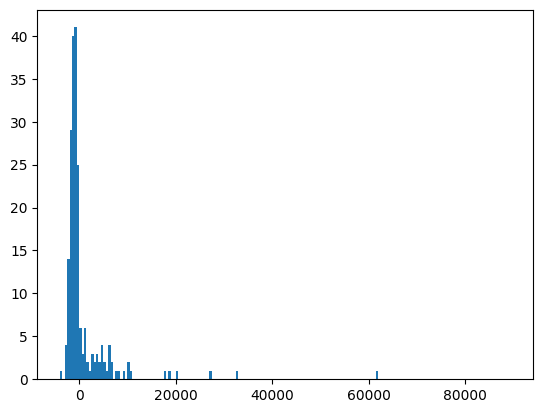

In [267]:
# create a histogram of the distribution of nova_profit_pyramid_sum
plt.hist(profit_df.loc[profit_df['nova_pyramid_entry_prices_length'] > 0, 'nova_profit_pyramid_sum'], bins=x)
plt.show()

In [268]:
# show the bins and counts from histogram in a table
nova_profit_pyramid_hist = np.histogram(profit_df.loc[profit_df['nova_pyramid_entry_prices_length'] > 0, 'nova_profit_pyramid_sum'], 
                                        bins=x)

# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_pyramid_hist[1][:-1], 'count': nova_profit_pyramid_hist[0]})
# drop rows that have 0 in the count column
nova_profit_hist_df = nova_profit_hist_df[nova_profit_hist_df['count'] != 0]
nova_profit_hist_df

,bin,count
0,-4000,1
2,-3000,4
3,-2500,14
4,-2000,29
5,-1500,40
6,-1000,41
7,-500,25
8,0,6
9,500,3
10,1000,6


In [59]:
# Complete profit calculation
if pyramid_bool:
    profit_df['nova_profit'] = profit_df['nova_profit_initial'] + nova_commission + profit_df['nova_swap_rate'] + profit_df['nova_profit_pyramid_sum']
    profit_df['msolutions_profit'] = profit_df['msolutions_profit_initial'] + msolutions_commission + profit_df['msolutions_swap_rate'] + profit_df['msolutions_profit_pyramid_sum']
else: 
    profit_df['nova_profit'] = profit_df['nova_profit_initial'] + nova_commission + profit_df['nova_swap_rate']
    profit_df['msolutions_profit'] = profit_df['msolutions_profit_initial'] + msolutions_commission + profit_df['msolutions_swap_rate']

In [60]:
# find the entry day of the week
profit_df['entry_day_of_week'] = profit_df['nova_entry_time'].dt.day_name()
profit_df['exit_day_of_week'] = profit_df['nova_exit_time'].dt.day_name()

# filter to just those entries on Friday
profit_df_friday = profit_df.loc[profit_df['entry_day_of_week'] == 'Friday']
# find where entry and exit day of the week are different
profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)
# find the number of times the entry and exit day of the week are different
weekend_hold = profit_df_friday.loc[profit_df_friday['entry_exit_day_of_week'] == 1]
weekend_hold

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_15544\2831238982.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)


,nova_entry_price,nova_entry_time,nova_exit_time,nova_exit_price,nova_direction,nova_brick_color,nova_news_event_5_total_bars,nova_news_event_5_entry,nova_profit_initial,nova_spread_exit_price,...,msolutions_profit_pyramid_sell,nova_profit_pyramid,nova_profit_pyramid_sum,msolutions_profit_pyramid,msolutions_profit_pyramid_sum,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,entry_exit_day_of_week
nova_cum_position_count,,,,,,,,,,,,,,,,,,,,,


## Daily Drawdown

In [61]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['nova_entry_time'] = pd.to_datetime(profit_df['nova_entry_time'])
profit_df_new_index = profit_df.set_index('nova_entry_time')
# find the sum of the nova and msolutions profit for each day
profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily['day_of_week'] = profit_df_daily.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily = profit_df_daily.loc[(profit_df_daily['day_of_week'] != 'Saturday') & (profit_df_daily['day_of_week'] != 'Sunday')]
# profit_df_daily.head(10)
# find the min of nova_profit and msolutions_profit
nova_min = profit_df_daily['nova_profit'].min()
msolutions_min = profit_df_daily['msolutions_profit'].min()
# find the days when nova_profit equals nova_min
profit_df_daily.loc[profit_df_daily['nova_profit'] == nova_min]
# 4 sma/smoothing and no pyramiding
# 2022-11-29	-2838.0/-3024.0

# 4 sma/smoothing and 4 pyramiding
# 2022-11-15	-3538.097248	-3992.597248

,nova_profit,msolutions_profit,day_of_week
nova_entry_time,,,
2022-11-15,-7356.0,-7996.5,Tuesday


In [62]:
# filter profit_df to show the cum_position_counts that ahve an entry_time between 2023-03-13 and 2023-03-14
profit_df_new_index_select_day = profit_df_new_index.loc['2024-03-11':'2024-03-12']
# save this to a csv
# profit_df_new_index_select_day.to_csv('profit_df_new_index_select_day_3_11_24_3_12_24.csv')
profit_df_new_index_select_day.nova_profit.sum()
# 4 sma/smoothing and no pyramiding 
# -1309.47

# 4 sma/smoothing and 4 pyramiding
# -1309.47


-1316.9999999999168

# End Values (Total Profit, Days in Drawdown)

In [63]:
# filter to just the last 3 months
profit_df_last_3_months = profit_df_new_index.loc['2023-12-11':]
# resample for each day and find the sum of the nova_profit and msolutions_profit
profit_df_daily_last_3_months = profit_df_last_3_months.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily_last_3_months['day_of_week'] = profit_df_daily_last_3_months.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily_last_3_months = profit_df_daily_last_3_months.loc[(profit_df_daily_last_3_months['day_of_week'] != 'Saturday') & (profit_df_daily_last_3_months['day_of_week'] != 'Sunday')]
# how many days were profitable in the last 3 months
profitable_days = len(profit_df_daily_last_3_months[profit_df_daily_last_3_months['nova_profit'] > 0].index)
print(profitable_days, profitable_days/len(profit_df_daily_last_3_months.index))
# 4 sma/smoothing and no pyramiding 
# 35, 0.47
# 4 sma/smoothing and 4 pyramiding
# 32 0.43243243243243246

25 0.33783783783783783


In [64]:
profit_df_daily_last_3_months

,nova_profit,msolutions_profit,day_of_week
nova_entry_time,,,
2023-12-11,-1317.0,-1363.5,Monday
2023-12-12,-162.0,-225.0,Tuesday
2023-12-13,21948.0,20673.0,Wednesday
2023-12-14,6306.0,2493.0,Thursday
2023-12-15,6669.0,6399.0,Friday
...,...,...,...
2024-03-15,0.0,0.0,Friday
2024-03-18,141.0,94.5,Monday
2024-03-19,0.0,0.0,Tuesday


In [65]:
# resample for each week and find the sum of the nova_profit and msolutions_profit
profit_df_weekly_last_3_months = profit_df_last_3_months.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
profit_df_weekly_last_3_months

,nova_profit,msolutions_profit
nova_entry_time,,
2023-12-17,33444.0,27976.5
2023-12-24,-1863.0,-2115.0
2023-12-31,2784.0,2574.0
2024-01-07,-849.0,3996.0
2024-01-14,-4452.0,-4833.0
2024-01-21,-792.0,-931.5
2024-01-28,303.0,-621.0
2024-02-04,4260.0,4405.5
2024-02-11,-1479.0,-1588.5


In [66]:
# find the total profit for nova and msolutions
nova_sum = profit_df_daily_last_3_months['nova_profit'].sum()
msolutions_sum = profit_df_daily_last_3_months['msolutions_profit'].sum()
print(f'Nova: {nova_sum}', f'MSolutions: {msolutions_sum}')
# 9.4 pip brick_size = Nova: 14,294.32 MSolutions: 12,587.32
# 8.1 pip brick_size = Nova: 19,594.83 MSolutions: 17,020.83

# 4 sma/smoothing and no pyramiding 
# Nova: 19594.825966293432 
# MSolutions: 17020.825966295717

# 4 sma/smoothing and 4 pyramiding
# Nova: 45,559.82
# MSolutions: 39,988.82

Nova: 30293.9999999954 MSolutions: 31963.50000000259


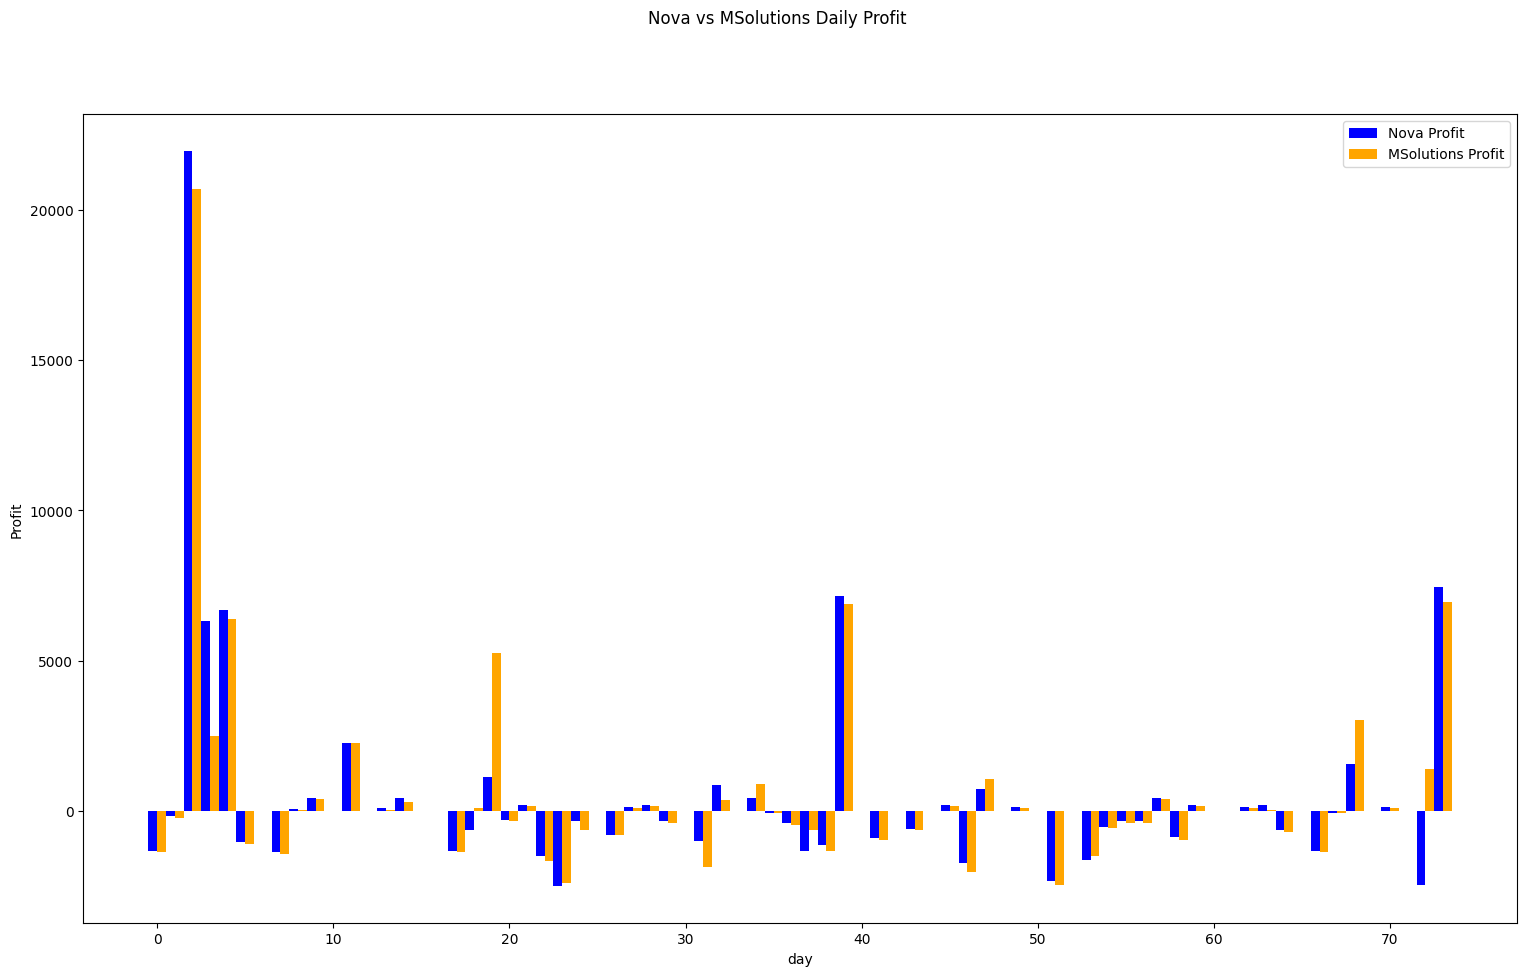

In [67]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily_last_3_months['day_number'] = profit_df_daily_last_3_months.index.dayofyear 
# add a column for the 
profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months['day_name'].astype(int)
# reset the index
profit_df_daily_last_3_months_reset = profit_df_daily_last_3_months.reset_index()

# Nova Profit
ax.bar(profit_df_daily_last_3_months_reset.index - width/2, profit_df_daily_last_3_months_reset['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily_last_3_months_reset.index + width/2, profit_df_daily_last_3_months_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()

In [68]:
# find the number of times that profit_df_daily is below zero
profit_df_daily['nova_negative'] = np.where(profit_df_daily['nova_profit'] < 0, 1, 0)
# find the sum of nova_negative and msolutions_negative
nova_negative_sum = profit_df_daily['nova_negative'].sum()
total_days = len(profit_df_daily.index)
total_profit = profit_df['nova_profit'].sum()
min_nova_daily = profit_df_daily['nova_profit'].min()
print(nova_negative_sum, total_days, nova_negative_sum/total_days, '${:,.2f}'.format(total_profit), min_nova_daily)

# 4 sma/smoothing and no pyramiding 
# 131 353 0.37110481586402266 $115,757.52 -2838.0000000003347

# 4 sma/smoothing and 4 pyramiding
# 153 353 0.43342776203966005 $403,211.52 -3538.097248103745

192 353 0.5439093484419264 $285,528.00 -7356.000000000318


## Summation and Plotting

In [69]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['nova_entry_time'] = pd.to_datetime(profit_df['nova_entry_time'])
profit_df_new_index = profit_df.set_index('nova_entry_time')
# find the sum of the nova and msolutions profit for each week
profit_df_weekly = profit_df_new_index.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit and msolutions_profit
nova_min = profit_df_weekly['nova_profit'].min()
msolutions_min = profit_df_weekly['msolutions_profit'].min()
nova_max = profit_df_weekly['nova_profit'].max()
msolutions_max = profit_df_weekly['msolutions_profit'].max()
nova_mean = profit_df_weekly['nova_profit'].mean()
msolutions_mean = profit_df_weekly['msolutions_profit'].mean()
print('nova_min: ', nova_min, 'msolutions_min: ', msolutions_min, 'nova_max: ', nova_max, 'msolutions_max: ', 
      msolutions_max, 'nova_mean: ', nova_mean, 'msolutions_mean: ', msolutions_mean)
# nova_min:  -1519.0033364526792 msolutions_min:  -2521.0033364526794 nova_max:  22138.90381578041 
# msolutions_max:  20752.90381578041 nova_mean:  5628.56341916719 msolutions_mean:  5032.650375688929

# 4 sma/smoothing and no pyramiding 
# nova_min:  -6573.248482601593 
# msolutions_min:  -7486.7484826008495 
# nova_max:  7819.516767982181 
# msolutions_max:  7603.516767982317 
# nova_mean:  1630.387577702303 
# msolutions_mean:  1325.1903946039768

# 4 sma/smoothing and 4 pyramiding
# nova_min:  -8,634.248482601351 
# msolutions_min:  -9,646.748482600222 
# nova_max:  64,497.15073200385
# msolutions_max:  63,783.150732006055 
# nova_mean:  5,679.035465025976 
# msolutions_mean:  5,038.767859392759

nova_min:  -16176.000000000442 msolutions_min:  -17270.999999999036 nova_max:  64496.99999999577 msolutions_max:  52424.99999999841 nova_mean:  4021.5211267601017 msolutions_mean:  3075.718309859312


In [870]:
# export profit_df to a csv file
# profit_df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/profit_df_new.csv')

In [871]:
# filter profit_df_weekly to just september 
# profit_df_weekly.loc['2023-09']

In [70]:
# use the entry time and resample to each day and find the sum of the profit
# profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('nova_entry_time')
# find the sum of the nova and msolutions profit for each month
profit_df_monthly = profit_df_new_index.resample('ME').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit
nova_min = profit_df_monthly['nova_profit'].min()
nova_max = profit_df_monthly['nova_profit'].max()
nova_mean = profit_df_monthly['nova_profit'].mean()
print('nova_min: ', nova_min, 'nova_max: ', nova_max, 'nova_mean: ', nova_mean)
# find where the nova_profit is equal to the nova_min
profit_df_monthly.loc[profit_df_monthly['nova_profit'] == nova_min]

# 4 sma/smoothing and no pyramiding 
# nova_min:  -3507.1797655590526 
# nova_max:  24962.975360037366 
# nova_mean:  6809.2657656978545

# 4 sma/smoothing and 4 pyramiding
# nova_min:  -1769.9829922384924 
# nova_max:  100,157.97536003285 
# nova_mean:  23,718.324589226133

nova_min:  -11601.000000002197 nova_max:  92684.99999999398 nova_mean:  16795.76470588042


,nova_profit,msolutions_profit
nova_entry_time,,
2022-12-31,-11601.0,-16119.0


In [71]:
profit_df_monthly

,nova_profit,msolutions_profit
nova_entry_time,,
2022-11-30,-4041.0,-6804.0
2022-12-31,-11601.0,-16119.0
2023-01-31,15807.0,13882.5
2023-02-28,20337.0,13761.0
2023-03-31,92685.0,84339.0
2023-04-30,16458.0,1089.0
2023-05-31,5274.0,15633.0
2023-06-30,13734.0,5692.5
2023-07-31,92316.0,60003.0


In [72]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
nova_end_balance = balance + profit_df['nova_profit'].sum()
# convert to dollars
nova_end_balance_dollars = '${:,.2f}'.format(nova_end_balance)
msolutions_end_balance = balance + profit_df['msolutions_profit'].sum()
msolutions_end_balance_dollars = '${:,.2f}'.format(msolutions_end_balance)
print(f'Nova End Balance: {nova_end_balance_dollars}')
print(f'MSolutions End Balance: {msolutions_end_balance_dollars}')
# 4 sma/smoothing and no pyramiding
# Nova End Balance: $315,757.52
# MSolutions End Balance: $294,088.52

# 4 sma/smoothing and 4 pyramiding
# Nova End Balance: $603,211.52
# MSolutions End Balance: $557,752.52

Nova End Balance: $485,528.00
MSolutions End Balance: $418,376.00


In [73]:
total_take_home = ((nova_end_balance-balance)*.8 )+ ((msolutions_end_balance-balance)*.75)
print(total_take_home)
# 163,172.40 - 4 sma/smoothing and no pyramiding
# 129,749.84 - 3 sma/smoothing and no pyramiding
# 590,883.60 - 4 sma/smoothing and 4 pyramiding

392204.3999999821


In [74]:
# calculate the win rate for nova
nova_win_rate = profit_df.loc[profit_df['nova_profit'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate = profit_df.loc[profit_df['msolutions_profit'] > 0].shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', nova_win_rate, 'MSolutions Win Rate: ', msolutions_win_rate)
# Nova Win Rate:  0.4040728831725616 MSolutions Win Rate:  0.4040728831725616 - 4 sma/smoothing and no pyramiding
# Nova Win Rate:  0.37916310845431256 MSolutions Win Rate:  0.37916310845431256 - 3 sma/smoothing and no pyramiding
# Nova Win Rate:  0.3762057877813505 MSolutions Win Rate:  0.3740621650589496 - 4 sma/smoothing and 4 pyramiding

Nova Win Rate:  0.28188638799571275 MSolutions Win Rate:  0.3022508038585209


In [75]:
# find the min for nova_profit and msolutions_profit
nova_min = profit_df['nova_profit'].min()
msolutions_min = profit_df['msolutions_profit'].min()
print(f'Nova Min: ${nova_min}')
print(f'MSolutions Min: ${msolutions_min}')
# find the max for nova_profit and msolutions_profit
nova_max = profit_df['nova_profit'].max()
msolutions_max = profit_df['msolutions_profit'].max()
print(f'Nova Max: ${nova_max}')
print(f'MSolutions Max: ${msolutions_max}')
# 4 sma/smoothing and no pyramiding
# Nova Min: $-796.9274479959886
# MSolutions Min: $-813.4274479959241
# Nova Max: $6014.999999999763
# MSolutions Max: $5998.499999999827

# 3 sma/smoothing and no pyramiding
# Nova Min: $-797.0341515714808
# MSolutions Min: $-813.5341515714165
# Nova Max: $4331.999999999862
# MSolutions Max: $4301.999999999838

# 4 sma/smoothing and 4 pyramiding
# Nova Min: $-1511.9999999999823
# MSolutions Min: $-1660.499999999403
# Nova Max: $67700.99999999582
# MSolutions Max: $67139.999999998

Nova Min: $-2666.999999999948
MSolutions Min: $-2798.9999999994325
Nova Max: $67700.99999999582
MSolutions Max: $55538.999999998436


In [76]:
# average RR ratio
# find the average RR ratio for nova_profit and msolutions_profit
# find the average profit for trades that were positive for nova_profit
nova_avg_profit = profit_df.loc[profit_df['nova_profit'] > 0]['nova_profit'].mean()
# find the average profit for trades that were negative for nova_profit
nova_avg_loss = profit_df.loc[profit_df['nova_profit'] < 0]['nova_profit'].mean()
nova_avg_profit/abs(nova_avg_loss)
# 2.4026609764044577
# 4 sma/smoothing and no pyramiding 
# 2.2973934737293487

# 4 sma/smoothing and 4 pyramiding
# 4.584709176903244 

5.056066693510297

In [77]:
# create a new column for cum_sum of nova_profit and msolutions_profit
profit_df['nova_cum_sum'] = profit_df['nova_profit'].cumsum()
profit_df['msolutions_cum_sum'] = profit_df['msolutions_profit'].cumsum()

In [78]:
# find the min of nova_cum_sum
nova_min_cum_sum_min = profit_df['nova_cum_sum'].min()
nova_min_cum_sum_min
# 4 sma/smoothing and no pyramiding 
# -7741.25

# 3 sma/smoothing and no pyramiding
# -14132.199224597824

# 4 sma/smoothing and 4 pyramiding
# -11296.252317561777

-18846.000000000116

In [79]:
# find the min of nova_cum_sum
msolutions_min_cum_sum_min = profit_df['msolutions_cum_sum'].min()
msolutions_min_cum_sum_min
# 4 sma/smoothing and no pyramiding 
# -9,043.05

# 4 sma/smoothing and 4 pyramiding
# -12,563.75

-25627.49999999247

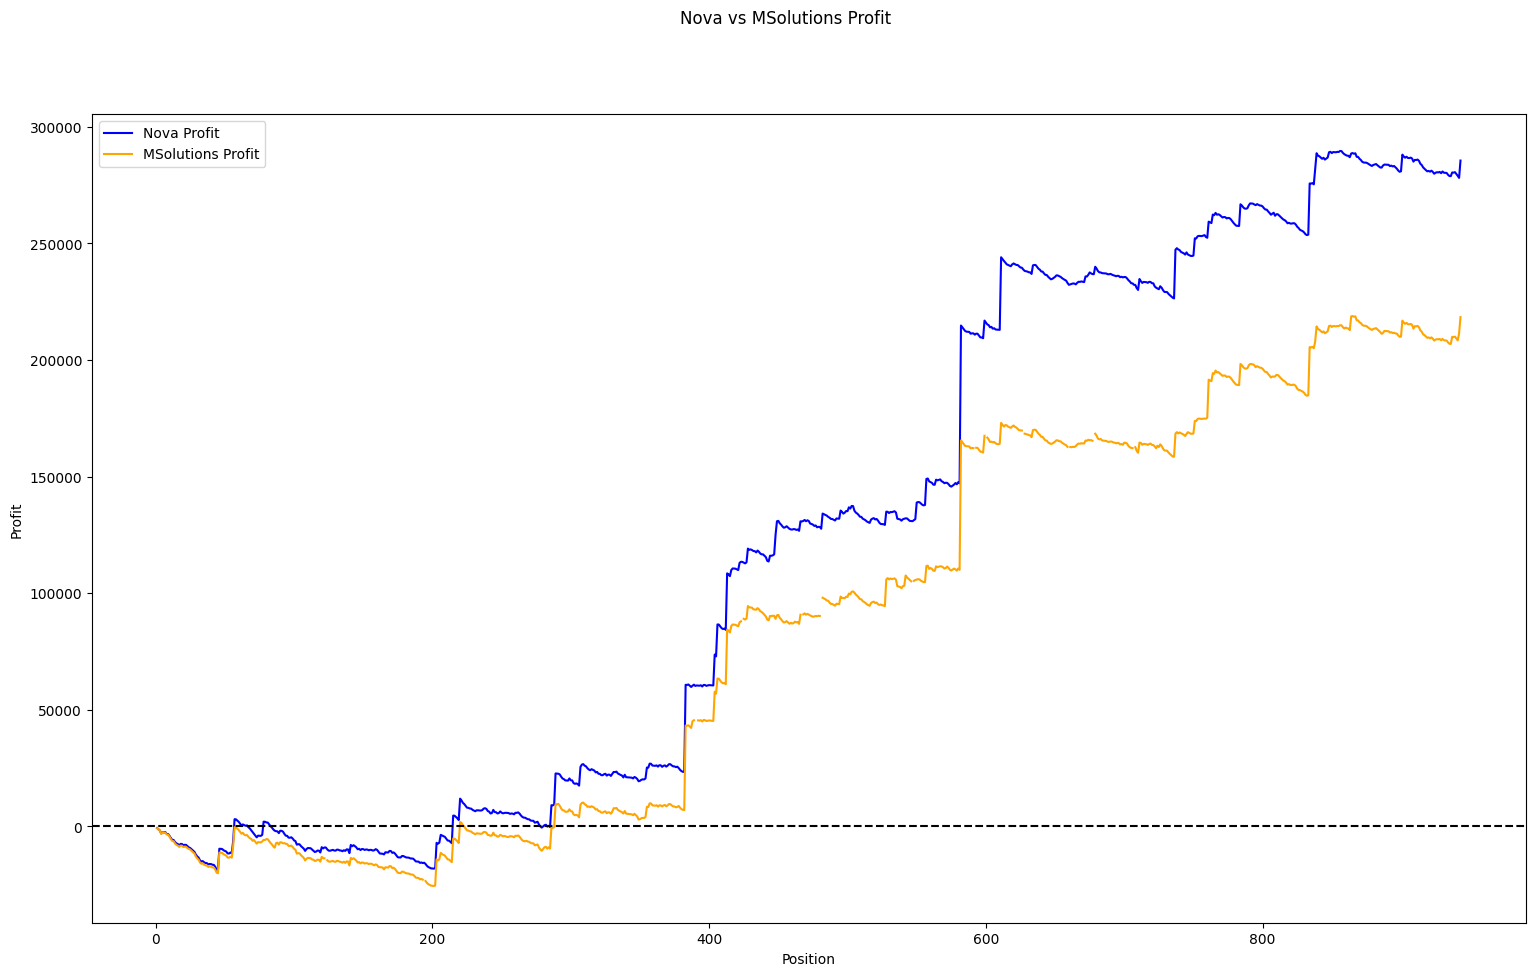

In [80]:
# graph nova_profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['nova_cum_sum'], label='Nova Profit', color='blue')
ax.plot(profit_df['msolutions_cum_sum'], label='MSolutions Profit', color='orange')
# add in a line for 0 
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Profit')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


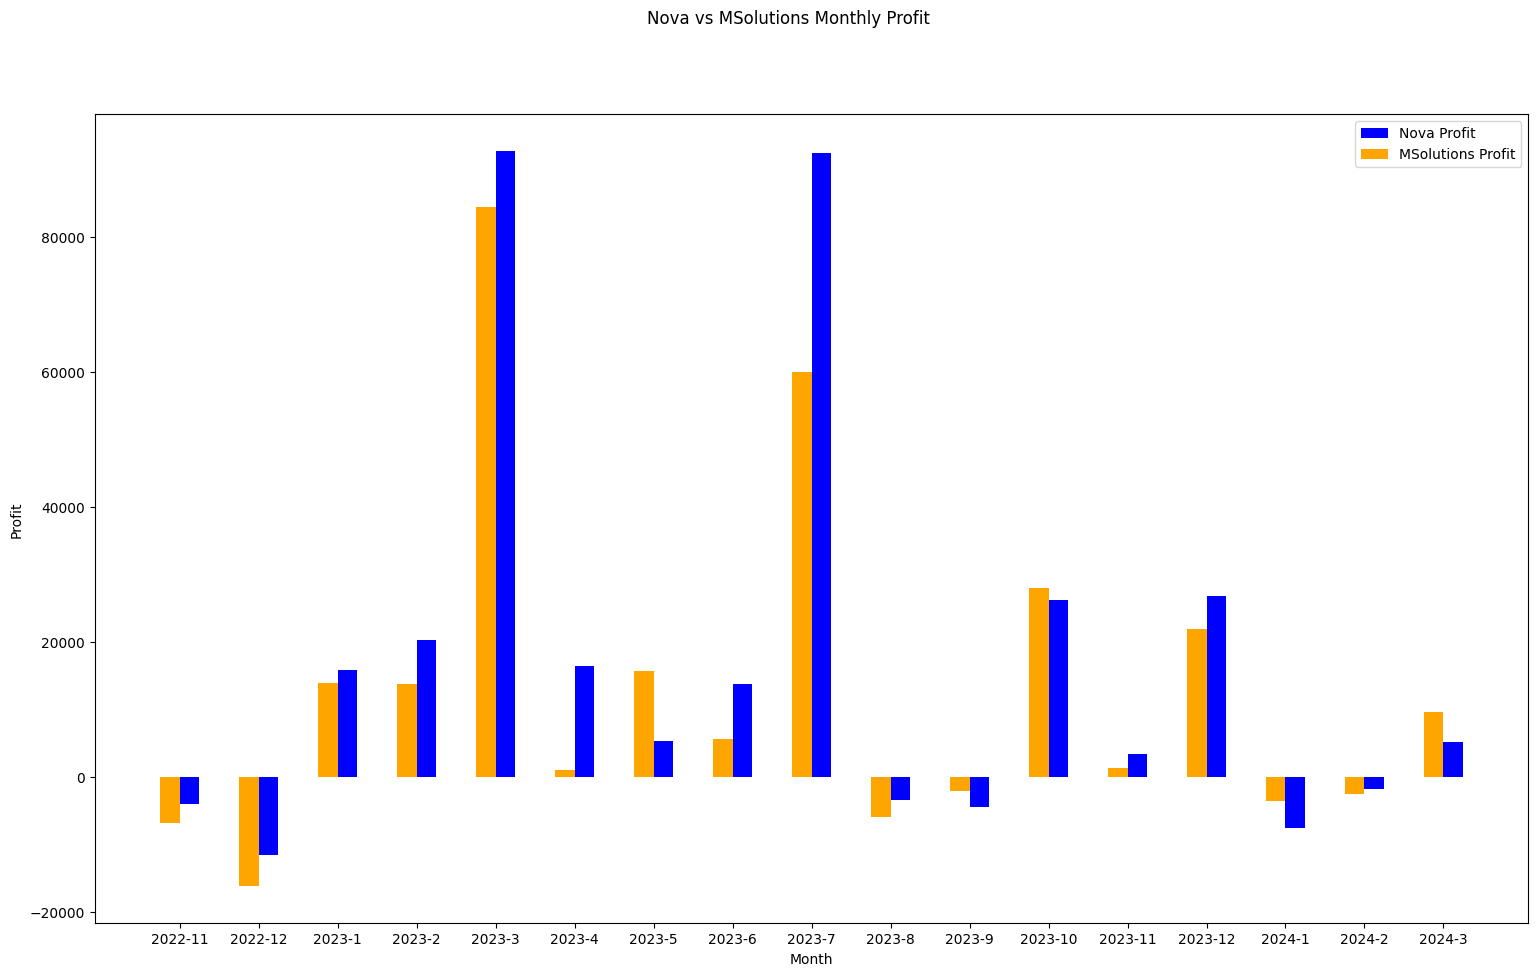

In [81]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly['month'] = profit_df_monthly.index.month
# add a column for the year
profit_df_monthly['year'] = profit_df_monthly.index.year
# concat the year and month like '2023-01'
profit_df_monthly['year_month'] = profit_df_monthly['year'].astype(str) + '-' + profit_df_monthly['month'].astype(str)
# add a column for the month name
profit_df_monthly['month_name'] = profit_df_monthly.index.strftime('%B')
# profit_df_monthly
# reindex the dataframe
profit_df_monthly_reset = profit_df_monthly.reset_index()

# Nova Profit
ax.bar(profit_df_monthly_reset.index + width/4, profit_df_monthly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_monthly_reset.index - width/4, profit_df_monthly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)

# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_monthly_reset.index)
ax.set_xticklabels(profit_df_monthly_reset['year_month'])

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


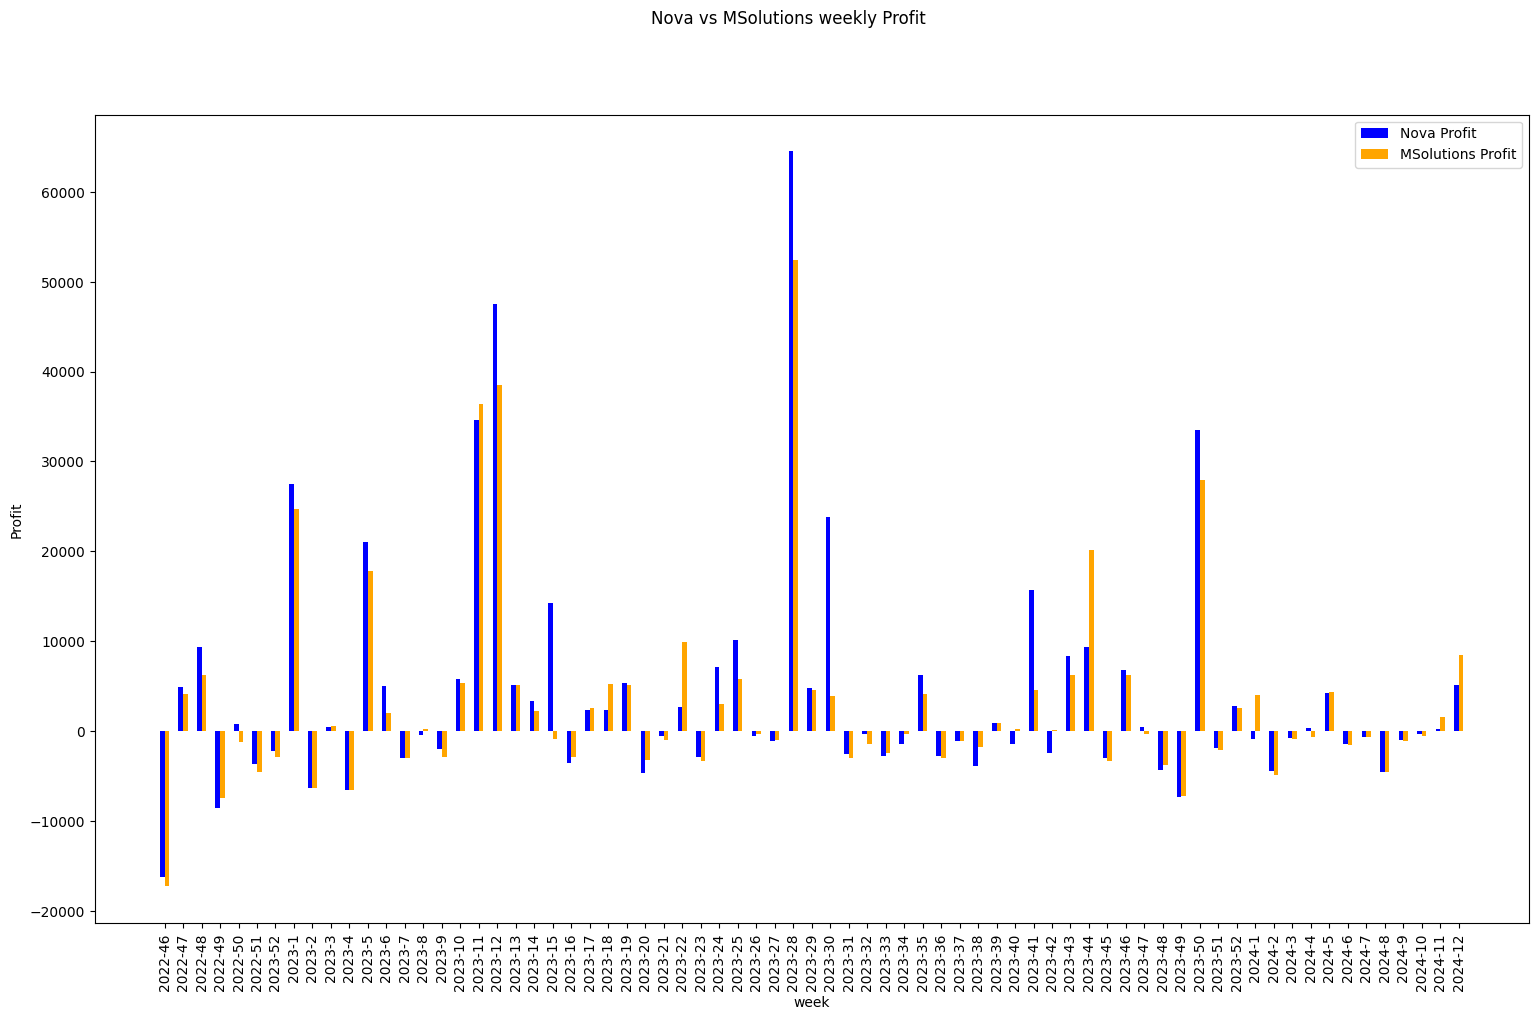

In [82]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_weekly['week'] = profit_df_weekly.index.isocalendar().week
# add a column for the week name
profit_df_weekly['week_name'] = profit_df_weekly.index.strftime('%U')
# convert the week_name to an integer
profit_df_weekly['week_name'] = profit_df_weekly['week_name'].astype(int)
# get the year
profit_df_weekly['year'] = profit_df_weekly.index.year
# concat the year and week like '2023-01'
profit_df_weekly['year_week'] = profit_df_weekly['year'].astype(str) + '-' + profit_df_weekly['week'].astype(str)
# reset the index
profit_df_weekly_reset = profit_df_weekly.reset_index()

# Nova Profit
ax.bar(profit_df_weekly_reset.index - width/4, profit_df_weekly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_weekly_reset.index + width/4, profit_df_weekly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)


# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_weekly_reset.index)
ax.set_xticklabels(profit_df_weekly_reset['year_week'])
# rotate the x axis labels vertically
plt.xticks(rotation=90)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions weekly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [83]:
# what is the median of nova_profit
nova_median = profit_df_weekly['nova_profit'].median()
print('Nova Median: ', nova_median)
# what is the average
nova_mean = profit_df_weekly['nova_profit'].mean()
print('Nova Mean: ', nova_mean)
# 4 sma/smoothing and no pyramiding 
# Nova Median:  1318.46
# Nova Mean:  1630.38

# 3 sma/smoothing and no pyramiding
# Nova Median:  1629.1363948608353
# Nova Mean:  1364.3034679851164

# 4 sma/smoothing and 4 pyramiding
# Nova Median:  1276.5555721774658
# Nova Mean:  5679.035465025976


Nova Median:  -285.0000000001452
Nova Mean:  4021.5211267601017


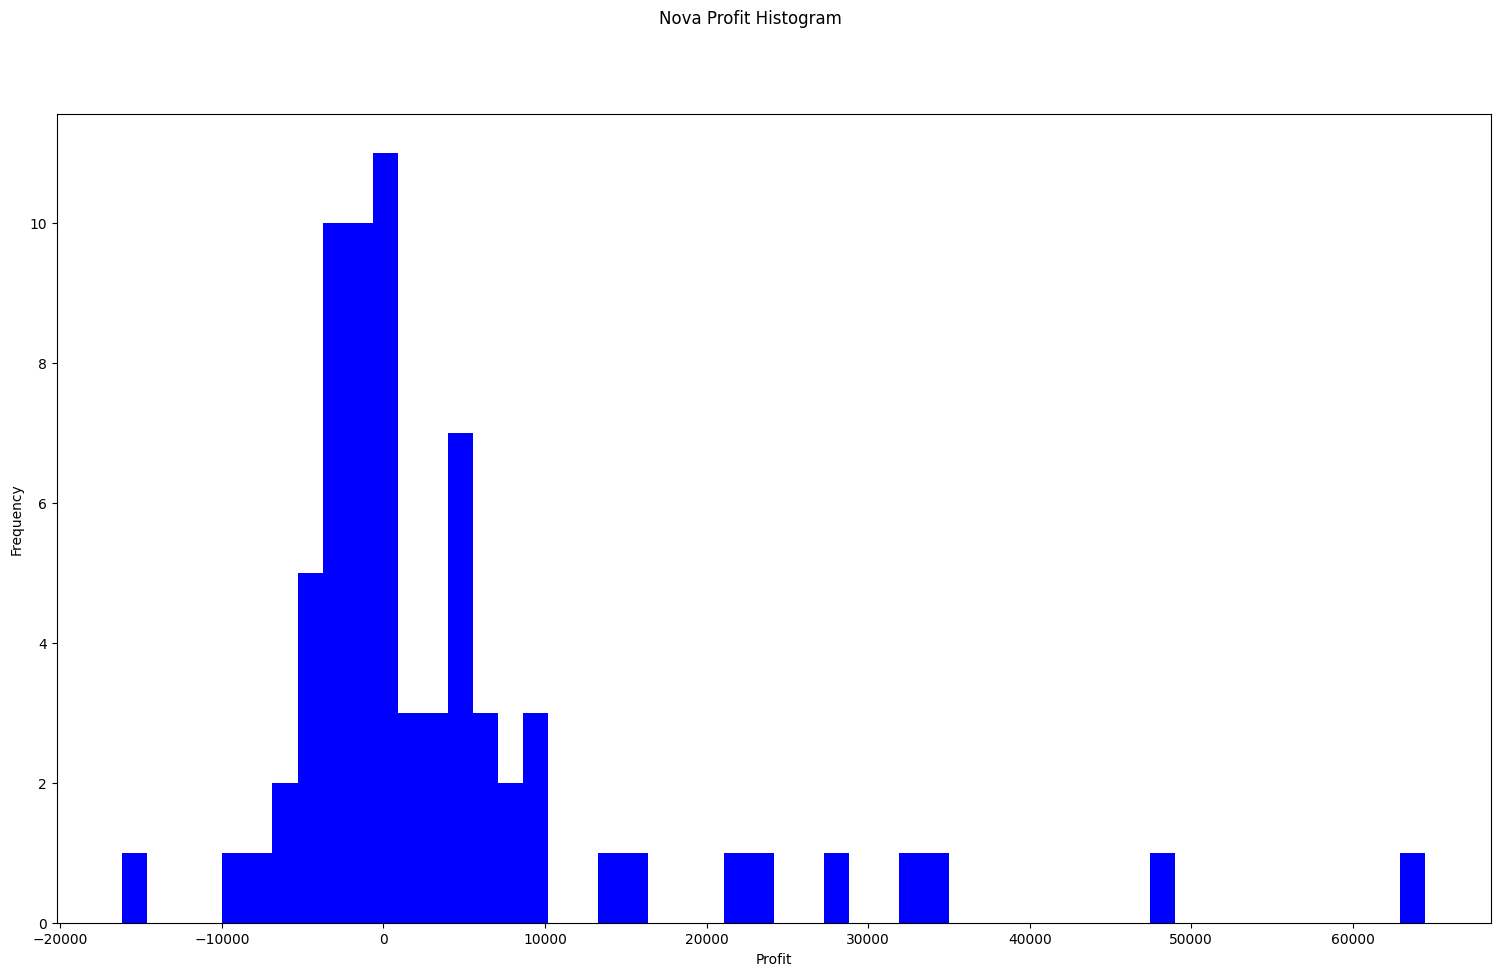

In [84]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


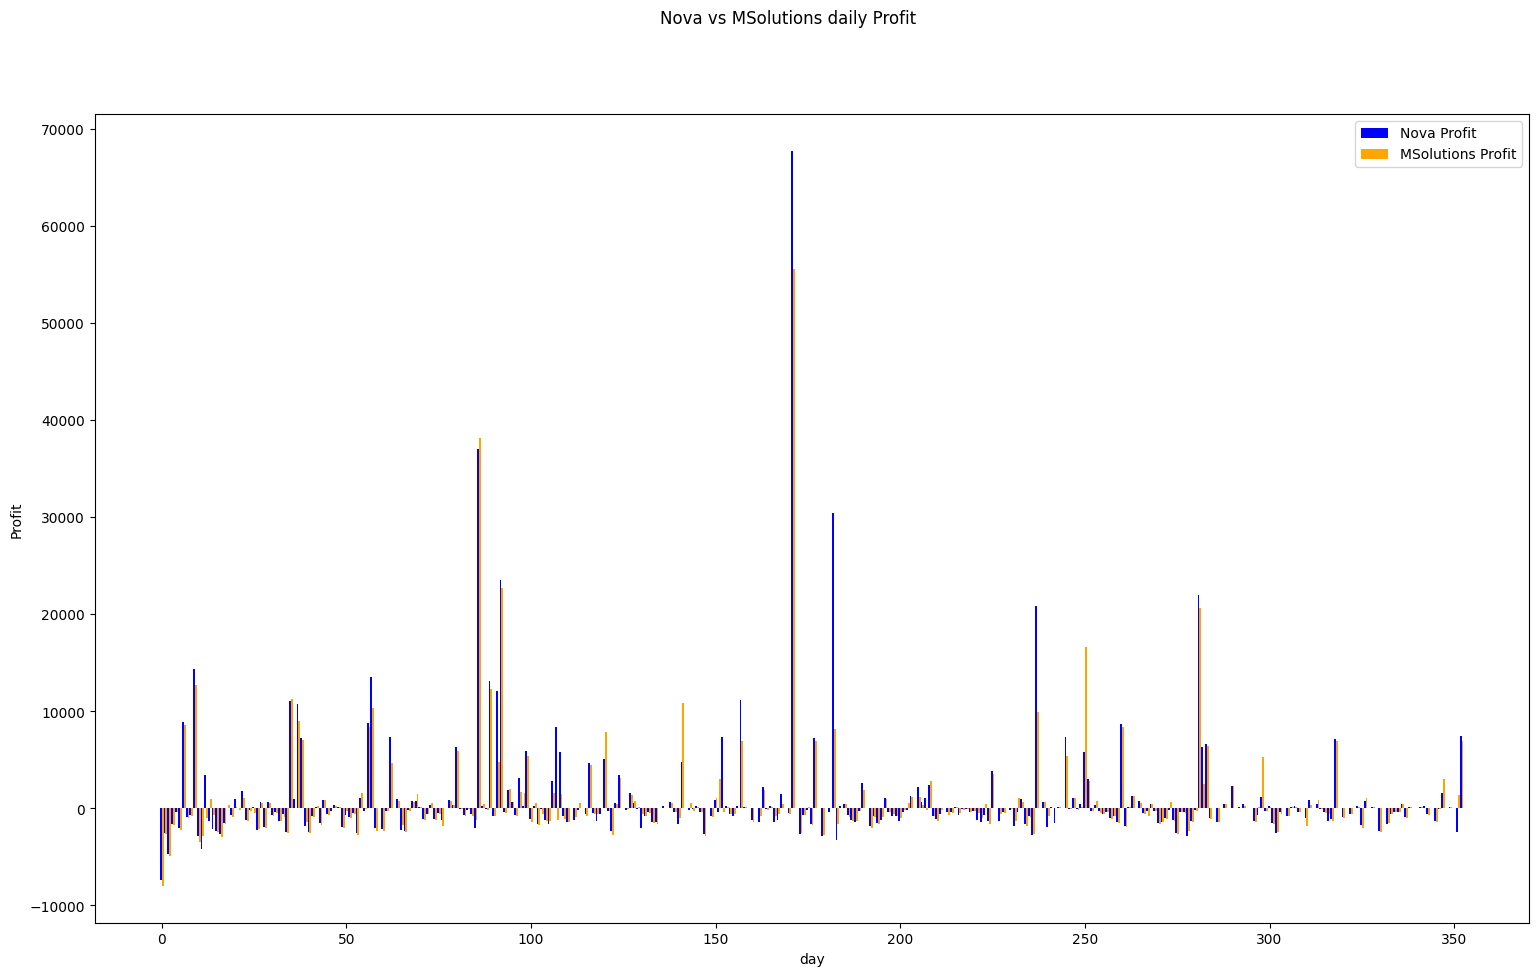

In [85]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily['day_number'] = profit_df_daily.index.dayofyear 
# add a column for the 
profit_df_daily['day_name'] = profit_df_daily.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily['day_name'] = profit_df_daily['day_name'].astype(int)
# reset the index
profit_df_daily_reset = profit_df_daily.reset_index()

# Nova Profit
ax.bar(profit_df_daily_reset.index - width/2, profit_df_daily_reset['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily_reset.index + width/2, profit_df_daily_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


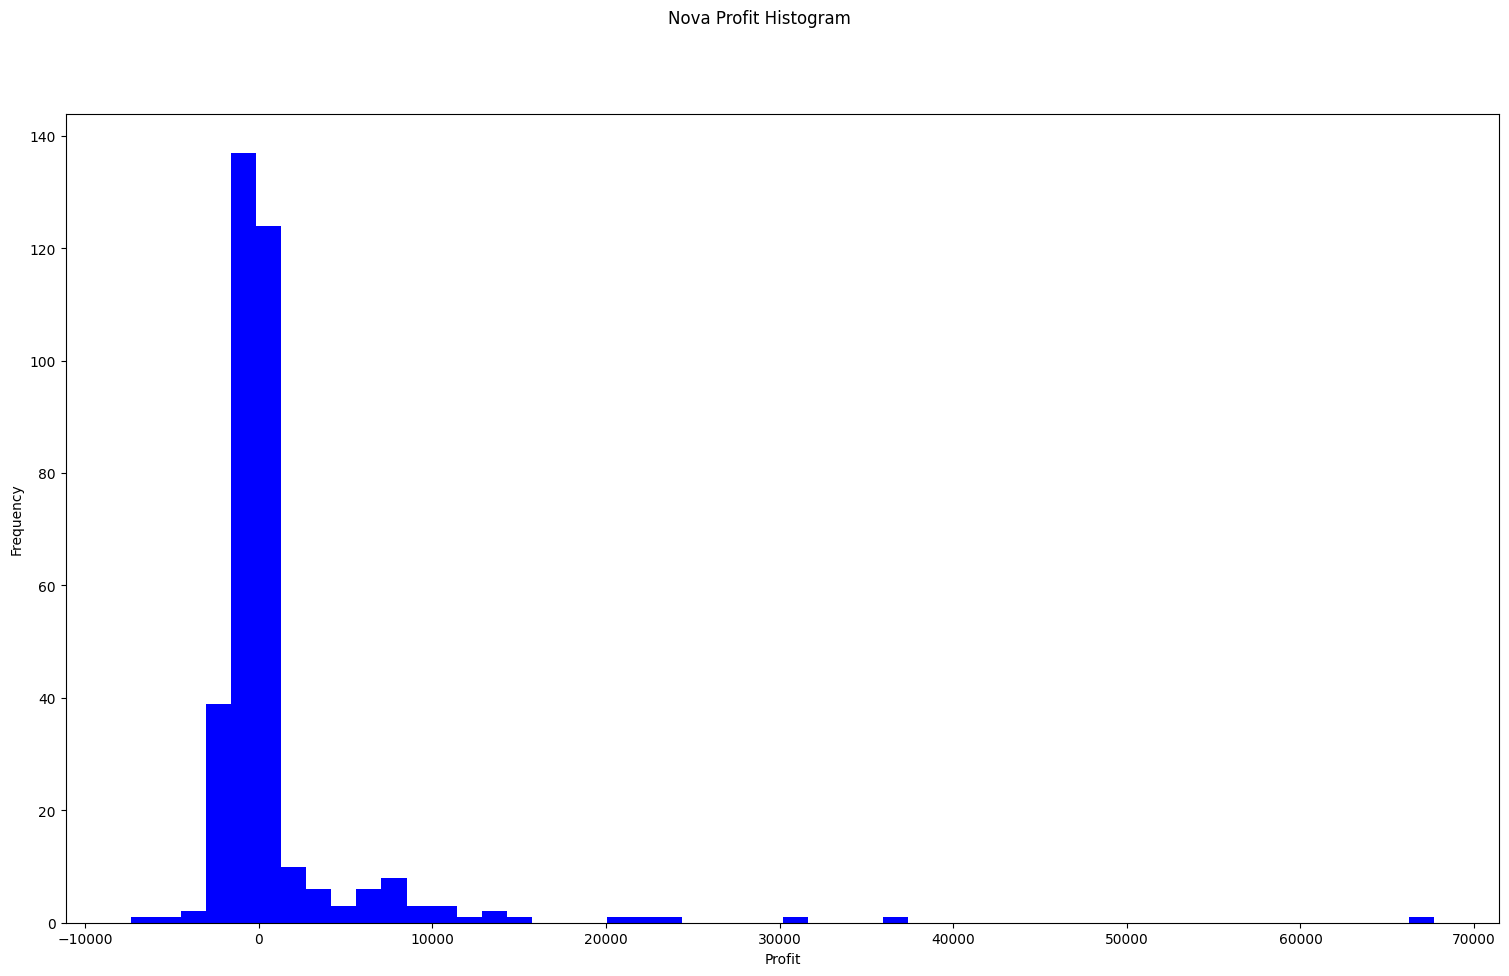

In [86]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [87]:
# show the bins and counts from histogram in a table
nova_profit_hist = np.histogram(profit_df_daily['nova_profit'], bins=52)
# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_hist[1][:-1], 'count': nova_profit_hist[0]})
nova_profit_hist_df


,bin,count
0,-7356.000000,1
1,-5912.596154,1
2,-4469.192308,2
3,-3025.788462,39
4,-1582.384615,137
5,-138.980769,124
6,1304.423077,10
7,2747.826923,6
8,4191.230769,3
9,5634.634615,6


In [89]:
# how many entry times were within 5 minutes of 8:30 am
# separate the hours and minutes from the entry_time column
# profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df['entry_hour'] = profit_df['nova_entry_time'].dt.hour
profit_df['entry_minute'] = profit_df['nova_entry_time'].dt.minute

# if the entry_hour is 8 and the entry_minute is between 25 and 35 then add a column called 'entry_8_30' and set it to 1
profit_df['entry_8_30'] = np.where((profit_df['entry_hour'] == 8) & (profit_df['entry_minute'] >= 25) & (profit_df['entry_minute'] <= 35), 1, 0)
# find the sum of the entry_8_30 column
entry_8_30_count = profit_df['entry_8_30'].sum()
print('Entry 8:30 Count: ', entry_8_30_count)

Entry 8:30 Count:  6


## Hour distribution

In [91]:
# find the win rate grouped by entry_hour and the number of trades taken for each hour
win_rate_by_hour = profit_df.groupby('entry_hour').agg({'nova_profit': lambda x: (x > 0).sum() / x.count(), 'nova_entry_time': 'count'})
win_rate_by_hour

,nova_profit,nova_entry_time
entry_hour,,
0,0.250000,8
1,0.250000,12
2,0.277778,18
3,0.304348,23
4,0.250000,16
5,0.300000,10
6,0.000000,4
7,0.400000,10
8,0.272727,23


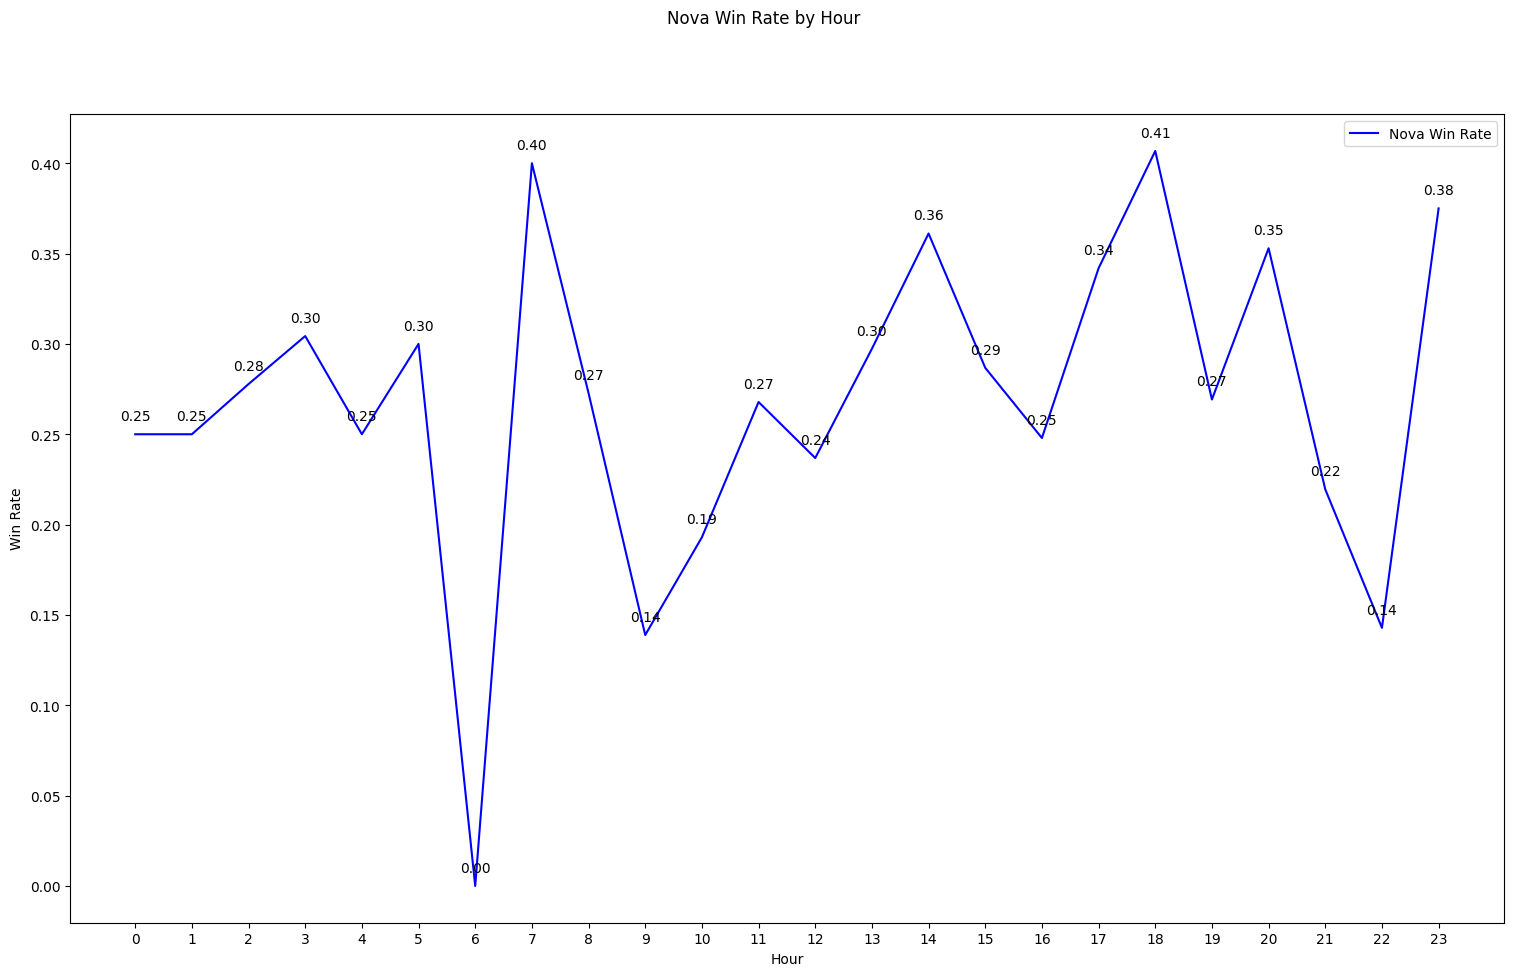

In [92]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
ax.plot(win_rate_by_hour.index, win_rate_by_hour['nova_profit'], label='Nova Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour['nova_profit']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour.index[i], win_rate_by_hour['nova_profit'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Nova Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [93]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0,23] #20, 21,
low_win_perc_removed = profit_df[~profit_df.entry_hour.isin(low_win_perc_hrs)]
# find the sum of nova profit for low_win_perc_removed
print(low_win_perc_removed['nova_profit'].sum(), profit_df['nova_profit'].sum())
# 450,269.5324621328 436,764.53246210545 (0,7,22,23)
# 447,864.53246212745 436,764.53246210545 - nighttime hours (0,22,23)


287903.9999999673 285527.9999999671


In [790]:
# export the profit_df to a csv
# profit_df.to_csv('profit_df.csv')

## Investigation of losing trades

In [791]:
# add a new column to profit_df that is the number of rows in renko_full_data for each position
profit_df['num_rows'] = renko_full_data.groupby('cum_position_count').size()
# filter profit_df to just the losing positions
losing_positions = profit_df[profit_df['nova_profit'] < 0]
min_loss = losing_positions.msolutions_profit.min()
losing_positions.loc[losing_positions['msolutions_profit'] == min_loss]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,nova_cum_sum,msolutions_cum_sum,entry_hour,entry_minute,entry_8_30,num_rows
cum_position_count,,,,,,,,,,,,,,,,,,,,,
102,1.04814,2022-12-07 11:31:16.256,2022-12-07 16:27:00.195,1.05219,buy,green,1164.0,1153.5,1.05209,1.05208,...,-1512.0,-1660.5,Wednesday,Wednesday,5952.948362,1595.448362,11,31,0,15


In [792]:
# create a list of all the losing position cum_position_count
losing_positions_list = losing_positions.index.tolist()
# find the average number of rows for each position in renko_full_data that are in the losing_positions_list
avg_rows = renko_full_data.loc[renko_full_data['cum_position_count'].isin(losing_positions_list)].shape[0] / len(losing_positions_list)
avg_rows

4.413080895008606

In [793]:
# find the standard deviation of num_rows in losing_positions
std_rows = losing_positions.num_rows.std()
max_losing_rows = losing_positions.num_rows.max()
min_losing_rows = losing_positions.num_rows.min()
# find the number of rows that occur the most
mode_losing_rows = losing_positions.num_rows.mode()
print('std_rows: ', std_rows, 'max_losing_rows: ', max_losing_rows, 'min_losing_rows: ', min_losing_rows, 
      'avg_rows: ', avg_rows, 'mode_losing_rows: ', mode_losing_rows)



std_rows:  2.908033043377559 max_losing_rows:  20 min_losing_rows:  1 avg_rows:  4.413080895008606 mode_losing_rows:  0    3
Name: num_rows, dtype: int64


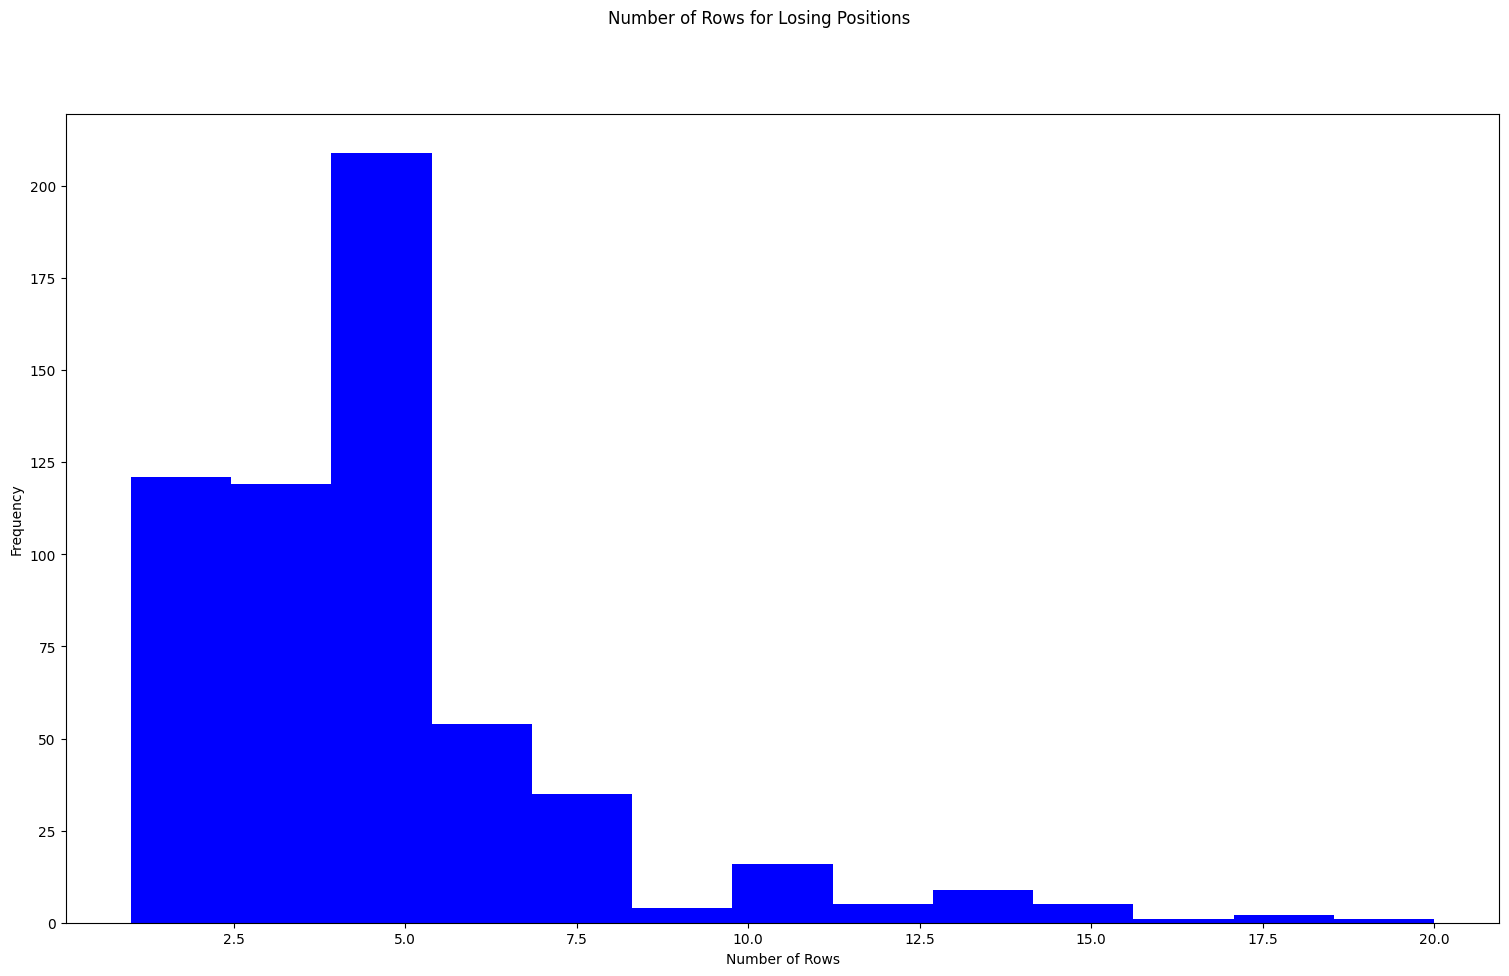

In [794]:
#create a histogram of the number of rows for the losing positions
fig, ax = plt.subplots()
ax.hist(losing_positions['num_rows'], bins=13, color='blue')
ax.set_xlabel('Number of Rows')
ax.set_ylabel('Frequency')
fig.suptitle('Number of Rows for Losing Positions')
fig.set_size_inches(18.5, 10.5)
plt.show()

In [795]:
losing_positions.loc[losing_positions['num_rows'] == 3]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,nova_cum_sum,msolutions_cum_sum,entry_hour,entry_minute,entry_8_30,num_rows
cum_position_count,,,,,,,,,,,,,,,,,,,,,
1,1.03923,2022-11-15 11:23:05.995,2022-11-15 12:31:05.758,1.04166,sell,red,-762.0,-786.0,1.04174,1.04174,...,-771.000000,-801.000000,Tuesday,Tuesday,-771.000000,-801.000000,11,23,0,3
8,1.04085,2022-11-15 17:34:07.233,2022-11-15 17:43:13.456,1.03842,buy,green,-780.0,-790.5,1.03832,1.03831,...,-789.000000,-805.500000,Tuesday,Tuesday,-1372.097248,-1558.097248,17,34,0,3
10,1.03842,2022-11-15 19:49:22.221,2022-11-15 20:25:58.801,1.03599,buy,green,-780.0,-790.5,1.03589,1.03588,...,-789.000000,-805.500000,Tuesday,Tuesday,-2203.097248,-2435.597248,19,49,0,3
12,1.03275,2022-11-15 20:44:09.501,2022-11-15 20:53:22.614,1.03032,buy,green,-780.0,-790.5,1.03022,1.03021,...,-789.000000,-805.500000,Tuesday,Tuesday,-2062.097248,-2341.097248,20,44,0,3
30,1.03518,2022-11-17 15:30:36.073,2022-11-17 15:42:21.320,1.03275,buy,green,-780.0,-790.5,1.03265,1.03264,...,-789.000000,-805.500000,Thursday,Thursday,-6977.188337,-7773.688337,15,30,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,1.07811,2024-02-08 20:02:47.395,2024-02-09 15:31:10.787,1.07811,buy,green,-51.0,-61.5,1.07801,1.07800,...,-60.000000,-76.500000,Thursday,Friday,397532.550699,353648.550699,20,2,0,3
924,1.08540,2024-02-29 17:01:02.151,2024-02-29 17:46:48.362,1.08297,buy,green,-780.0,-790.5,1.08287,1.08286,...,-789.000000,-805.500000,Thursday,Thursday,397549.018688,352957.018688,17,1,0,3
934,1.09431,2024-03-12 15:41:12.450,2024-03-12 15:59:05.393,1.09188,buy,green,-780.0,-790.5,1.09178,1.09177,...,-789.000000,-805.500000,Tuesday,Tuesday,397094.429209,352220.429209,15,41,0,3


In [796]:
# what was the cum_position_count for the position with the max_losing_rows
max_losing_rows_cum_position_count = losing_positions.loc[losing_positions['num_rows'] == max_losing_rows].index[0]
# filter renko_full_data to just the rows with the min_losing_rows_cum_position_count
renko_full_data.loc[renko_full_data['cum_position_count'] == max_losing_rows_cum_position_count]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2023-09-13 16:13:29.450,1.07406,1.07416,1.07325,1.07325,629.0,1.073680,1.074524,1.074657,-0.000133,-1.0,...,sell,red,Wednesday,0,1.07082,1.07568,1,693,0,2023-09-13 16:13:29.450
2023-09-13 16:24:09.956,1.07406,1.07487,1.07292,1.07487,2116.0,1.074180,1.074379,1.074639,-0.000260,-1.0,...,sell,green,Wednesday,0,NaN,1.07568,0,693,0,2023-09-13 16:24:09.956
2023-09-13 17:04:34.328,1.07406,1.07558,1.07325,1.07325,8431.0,1.074035,1.074169,1.074492,-0.000323,-1.0,...,sell,red,Wednesday,0,NaN,1.07568,0,693,0,2023-09-13 17:04:34.328
2023-09-13 20:47:36.485,1.07406,1.07487,1.07271,1.07487,18373.0,1.074127,1.074006,1.074270,-0.000264,-1.0,...,sell,green,Wednesday,0,NaN,1.07568,0,693,0,2023-09-13 20:47:36.485
2023-09-13 21:55:30.697,1.07406,1.07491,1.07325,1.07325,2872.0,1.073867,1.074052,1.074152,-0.000099,-1.0,...,sell,red,Wednesday,0,NaN,1.07568,0,693,0,2023-09-13 21:55:30.697
2023-09-14 07:21:39.194,1.07406,1.07487,1.07278,1.07487,18154.0,1.074145,1.074044,1.074068,-0.000024,-1.0,...,sell,green,Thursday,0,NaN,1.07568,0,693,0,2023-09-14 07:21:39.194
2023-09-14 11:00:05.663,1.07406,1.07521,1.07325,1.07325,9559.0,1.073942,1.074021,1.074031,-0.000010,-1.0,...,sell,red,Thursday,0,NaN,1.07568,0,693,0,2023-09-14 11:00:05.663
2023-09-14 15:15:32.168,1.07325,1.07476,1.07244,1.07244,14925.0,1.073222,1.073794,1.073978,-0.000183,-1.0,...,sell,red,Thursday,0,NaN,1.07568,0,693,0,2023-09-14 15:15:32.168
2023-09-14 15:15:34.961,1.07244,1.07244,1.07163,1.07163,35.0,1.072035,1.073336,1.073799,-0.000462,-1.0,...,sell,red,Thursday,0,NaN,1.07568,0,693,0,2023-09-14 15:15:34.961


C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\2309009150.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_259.drop(columns=['datetime'], inplace=True)


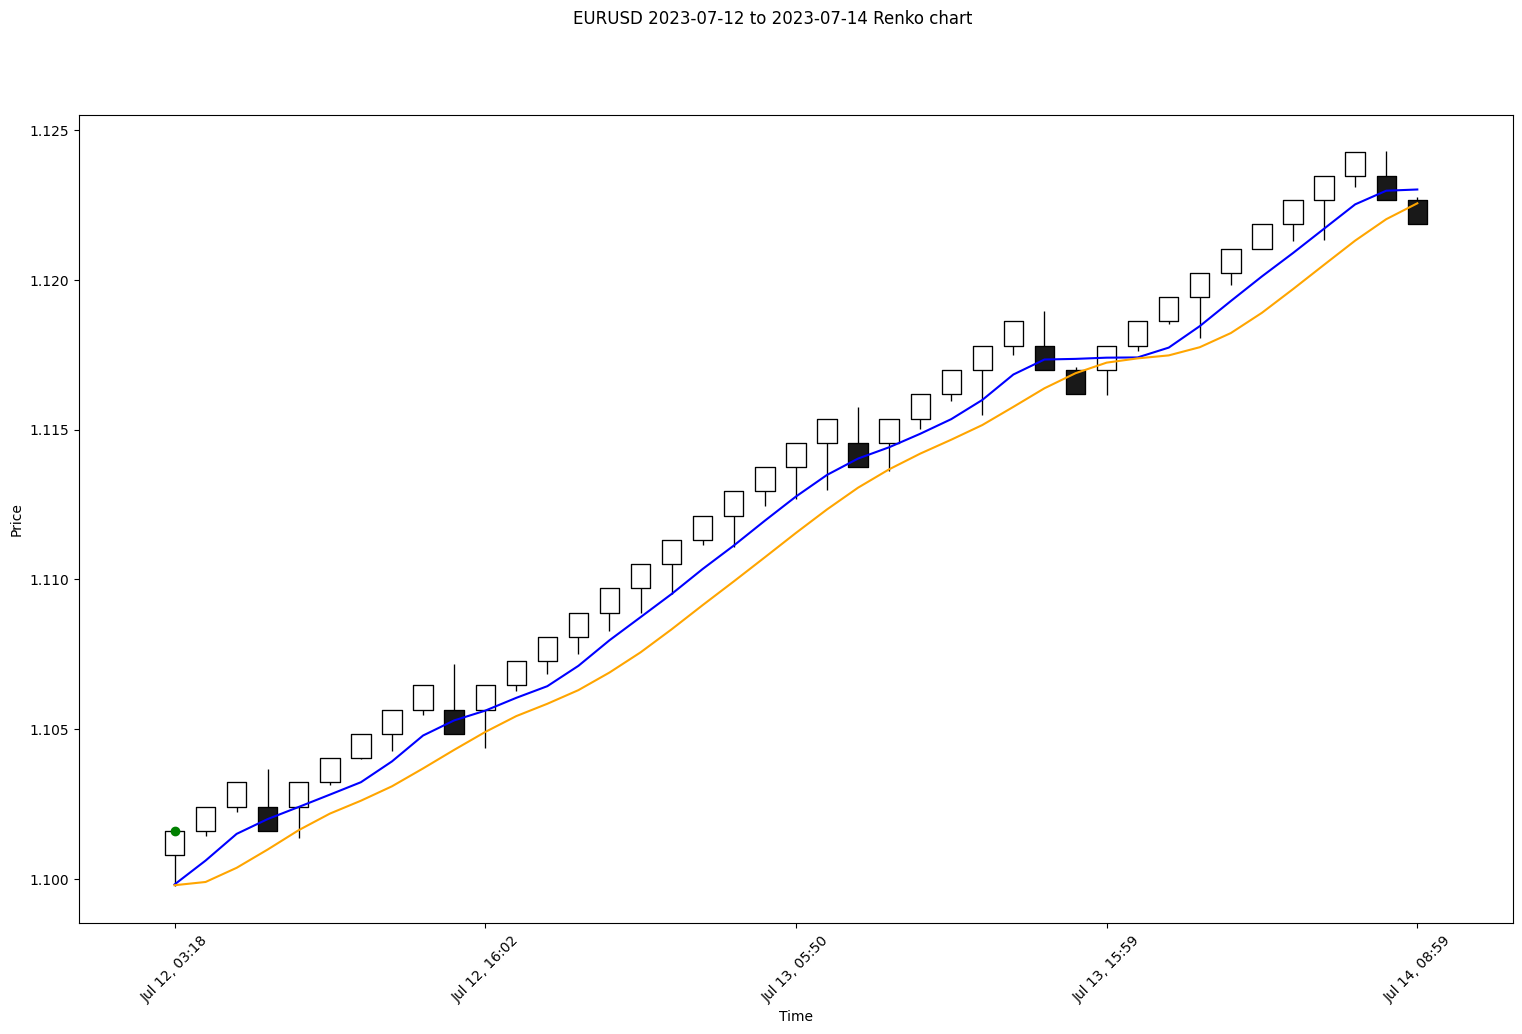

In [797]:
# filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
renko_full_data_259 = renko_full_data.loc[renko_full_data['cum_position_count'] == 582]
# impulse_graph(renko_full_data_259, 'md', 'sb')
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_259, type='candle', ax=ax, volume=False, show_nontrading=False)
# drop datetime
renko_full_data_259.drop(columns=['datetime'], inplace=True)
renko_full_data_259_reset = renko_full_data_259.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_259_reset.index, renko_full_data_259['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_259_reset.index, renko_full_data_259['smoothing_sma'], label='SmoothingSMA', color='orange')
# add a column to renko_full_data_259_reset that copies the close price when sma_crossover is 1 or -1
renko_full_data_259_reset['sma_crossover_price_buy'] = np.where(renko_full_data_259['sma_crossover'] == 1, renko_full_data_259['close'], np.nan)
renko_full_data_259_reset['sma_crossover_price_sell'] = np.where(renko_full_data_259['sma_crossover'] == -1, renko_full_data_259['close'], np.nan)
# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# find the date of the first and last index
first_date = renko_full_data_259_reset['datetime'].iloc[0]
last_date = renko_full_data_259_reset['datetime'].iloc[-1]
fig.suptitle(f'EURUSD {first_date.date()} to {last_date.date()} Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [798]:
# filter to just cum_position_count = 3 in renko_full_data
renko_full_data.loc[renko_full_data['cum_position_count'] == 3]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-15 14:15:25.349,1.04085,1.04095,1.04004,1.04004,1787.0,1.040470,1.041744,1.041845,-0.000101,-1.0,...,sell,red,Tuesday,0,1.03761,1.04247,1,3,0,2022-11-15 14:15:25.349
2022-11-15 15:20:01.809,1.04004,1.04133,1.03923,1.03923,12625.0,1.039957,1.041021,1.041731,-0.000710,-1.0,...,sell,red,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:20:01.809
2022-11-15 15:30:04.374,1.04004,1.04085,1.03920,1.04085,2514.0,1.040235,1.040486,1.041344,-0.000858,-1.0,...,sell,green,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:30:04.374
2022-11-15 15:30:05.830,1.04085,1.04166,1.04085,1.04166,19.0,1.041255,1.040479,1.040933,-0.000453,-1.0,...,sell,green,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:30:05.830


In [799]:
# filter to just cum_position_count = 3 in renko_full_data
renko_full_data.loc[renko_full_data['cum_position_count'] == 70]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-30 16:17:23.879,1.03842,1.03923,1.03838,1.03923,490.0,1.038815,1.037588,1.037497,0.000091,1.0,...,buy,green,Wednesday,0,1.04166,1.0368,1,70,0,2022-11-30 16:17:23.879
2022-11-30 17:00:22.811,1.03842,1.03998,1.03761,1.03761,11118.0,1.038405,1.038027,1.037553,0.000474,1.0,...,buy,red,Wednesday,0,NaN,1.0368,0,70,0,2022-11-30 17:00:22.811
2022-11-30 17:06:06.152,1.03761,1.03806,1.03680,1.03680,2337.0,1.037317,1.038124,1.037751,0.000372,1.0,...,buy,red,Wednesday,0,NaN,1.0368,0,70,1,2022-11-30 17:06:06.152
